In [328]:
import pandas as pd
import os
from os import path
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import sklearn
import pylab as py
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from tqdm import tqdm
from scipy import sparse
import csv, random, numpy, os, re, nltk, scipy, gensim
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from langdetect import detect
from sklearn.ensemble import RandomForestClassifier
from csv import DictReader
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import score
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")



In [386]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
def plot_freuecncy_distrubuation(cat_feature,col_name):
    cat_feature_count = cat_feature[col_name].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(cat_feature_count.index, cat_feature_count.values, alpha=0.9)
    plt.title('Frequency Distribution of '+col_name)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(col_name, fontsize=12)
    plt.show()

In [330]:
def plot_freuecncy_distrubuation_pie(cat_feature,col_name):
    labels = cat_feature[col_name].astype('category').cat.categories.tolist()
    counts = cat_feature[col_name].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    fig1, ax1 = plt.subplots()
    plt.title('Frequency Distribution of '+col_name)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
    ax1.axis('equal')
    plt.show()

classes = ['0', '1']



In [331]:
def report_score(test,pred,algo):
    #accuracy calculation
    accuracy = accuracy_score(test,pred)
    print('\n Accuracy_score for %s = %s \n'%(algo,accuracy))

    #confusion_matrix
    mat = confusion_matrix(test,pred)
    fig, ax = plt.subplots(figsize=(11,11))  
    ax.set_title("Confusion Matrix for %s" %algo)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap="icefire",
                xticklabels=classes,yticklabels=classes,linewidths=.3, ax=ax)
    plt.xlabel('True label')
    plt.ylabel('Predicted label');

    #classification report
    cls = classification_report(test,pred, target_names=classes)
    print(cls)

In [332]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Function to get roc curve
def get_roc (y_test,y_pred,title):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="upper left")
    plt.show()
    return


In [333]:
from sklearn.metrics import  average_precision_score, precision_recall_curve


# Function to get Precision recall curve
def get_prec_recall (y_test,y_pred):
    average_precision = average_precision_score(y_test, y_pred)
    print('Average precision-recall score : {}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,color='cyan')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    return

In [334]:
train = pd.read_csv('TrainingData.csv')
UnknowData = pd.read_csv('UnknowData.csv')
# y_labels = pd.read_csv('Kaggle-Submission-Ramdom-Sample.csv')
print(train.shape)
train.head()

(62580, 30)


,Quote_Id,Quote_Date,Quote_Flag,Field_info1,Field_info2,Field_info3,Field_info4,Coverage_info1,Coverage_info2,Coverage_info3,...,Property_info1,Property_info2,Property_info3,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3,Geographic_info4,Geographic_info5
0,2,14/5/14,0,B,0.9153,935,N,5,2,D,...,N,0,D,1,6,2,13,-1,N,CA
1,3,19/6/13,0,J,0.9691,"1,165",N,5,22,F,...,N,0,D,1,8,14,7,-1,N,TX
2,6,6/2/15,0,B,0.9153,935,N,6,22,D,...,N,0,D,1,11,2,12,-1,N,CA
3,9,15/10/14,0,J,0.8793,"1,113",N,1,22,F,...,N,0,O,0,1,14,6,-1,N,TX
4,10,30/3/15,1,F,1.0101,548,N,13,22,E,...,N,0,R,1,25,4,22,-1,N,NJ


In [335]:
print(UnknowData.shape)
UnknowData.head()

(41721, 29)


,Quote_Id,Quote_Date,Field_info1,Field_info2,Field_info3,Field_info4,Coverage_info1,Coverage_info2,Coverage_info3,Sales_info1,...,Property_info1,Property_info2,Property_info3,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3,Geographic_info4,Geographic_info5
0,1,25/1/14,E,0.9472,"1,487",N,8,22,F,1,...,Y,0,D,0,11,9,22,-1,N,IL
1,4,18/6/13,F,0.9919,564,N,11,22,E,0,...,N,0,R,1,14,4,17,-1,N,NJ
2,5,24/9/13,B,0.9403,965,N,4,22,J,0,...,N,0,O,0,18,2,11,-1,N,CA
3,7,15/9/14,B,0.9153,935,N,12,22,D,1,...,N,0,D,1,24,2,12,-1,N,CA
4,8,18/6/13,E,0.9485,"1,480",N,5,22,K,1,...,N,0,R,0,4,9,23,-1,N,IL


In [336]:
# print(y_labels.shape)
# y_labels.head()

In [337]:
print("Shape of Train Data: ",train.shape)
print("Shape of Test  Data: ",UnknowData.shape)
# print(y_labels.shape)

Shape of Train Data:  (62580, 30)
Shape of Test  Data:  (41721, 29)


In [338]:
print("Total Null in All Featuers",train.isnull().values.sum())
print("column-wise distribution of null values:\n",train.isnull().sum())

Total Null in All Featuers 29828
column-wise distribution of null values:
 Quote_Id                0
Quote_Date              0
Quote_Flag              0
Field_info1             0
Field_info2             0
Field_info3             0
Field_info4             0
Coverage_info1          0
Coverage_info2          0
Coverage_info3          0
Sales_info1             0
Sales_info2             0
Sales_info3             0
Sales_info4             0
Sales_info5             0
Personal_info1         23
Personal_info2          0
Personal_info3          0
Personal_info4          0
Personal_info5      29788
Property_info1         16
Property_info2          0
Property_info3          0
Property_info4          0
Property_info5          0
Geographic_info1        0
Geographic_info2        0
Geographic_info3        0
Geographic_info4        1
Geographic_info5        0
dtype: int64


In [339]:
train_numeric_features = train.select_dtypes('number')
train_numeric_features = train_numeric_features.drop(['Quote_Flag','Quote_Id'], axis=1)
train_numeric_features.shape
print("Total Null in Numeric Featuers-----------------:",train_numeric_features.isnull().values.sum())
print("column-wise distribution of null values----:\n\n",train_numeric_features.isnull().sum())
train_numeric_features.info
print(train_numeric_features.describe())

Total Null in Numeric Featuers-----------------: 29788
column-wise distribution of null values----:

 Field_info2             0
Coverage_info1          0
Coverage_info2          0
Sales_info1             0
Sales_info2             0
Sales_info3             0
Sales_info5             0
Personal_info2          0
Personal_info4          0
Personal_info5      29788
Property_info2          0
Property_info4          0
Property_info5          0
Geographic_info1        0
Geographic_info2        0
Geographic_info3        0
dtype: int64
        Field_info2  Coverage_info1  Coverage_info2   Sales_info1  \
count  62580.000000    62580.000000    62580.000000  62580.000000   
mean       0.938307        8.999057       21.197779      0.745973   
std        0.037030        5.575434        4.926863      0.435316   
min        0.874600       -1.000000        1.000000      0.000000   
25%        0.915300        5.000000       22.000000      0.000000   
50%        0.940300        8.000000       22.000000    

In [340]:
cat_df_train = train.select_dtypes(include=['object']).copy()
cat_df_train.head()

,Quote_Date,Field_info1,Field_info3,Field_info4,Coverage_info3,Sales_info4,Personal_info1,Personal_info3,Property_info1,Property_info3,Geographic_info4,Geographic_info5
0,14/5/14,B,935,N,D,T,N,ZA,N,D,N,CA
1,19/6/13,J,"1,165",N,F,P,N,XR,N,D,N,TX
2,6/2/15,B,935,N,D,V,N,ZA,N,D,N,CA
3,15/10/14,J,"1,113",N,F,Q,N,ZA,N,O,N,TX
4,30/3/15,F,548,N,E,K,N,XD,N,R,N,NJ


In [341]:
print("Total Null in categorical Featuers",cat_df_train.isnull().values.sum())
print("column-wise distribution of null values:\n",cat_df_train.isnull().sum())

Total Null in categorical Featuers 40
column-wise distribution of null values:
 Quote_Date           0
Field_info1          0
Field_info3          0
Field_info4          0
Coverage_info3       0
Sales_info4          0
Personal_info1      23
Personal_info3       0
Property_info1      16
Property_info3       0
Geographic_info4     1
Geographic_info5     0
dtype: int64


In [342]:
cat_df_train = cat_df_train.fillna(cat_df_train['Personal_info1'].value_counts().index[0])
print("column-wise distribution of null values:\n",cat_df_train.isnull().sum())
print(cat_df_train['Field_info1'].value_counts())

column-wise distribution of null values:
 Quote_Date          0
Field_info1         0
Field_info3         0
Field_info4         0
Coverage_info3      0
Sales_info4         0
Personal_info1      0
Personal_info3      0
Property_info1      0
Property_info3      0
Geographic_info4    0
Geographic_info5    0
dtype: int64
B    22809
F    16444
J    12371
E     6375
K     3166
C     1342
D       63
A       10
Name: Field_info1, dtype: int64


In [343]:

# print("Unique Categories in Quote_Date--------: ",cat_df_train['Quote_Date'].value_counts().count())
print("Unique Categories in Field_info1-------: ",cat_df_train['Field_info1'].value_counts().count())
print("Unique Categories in Field_info3-------: ",cat_df_train['Field_info3'].value_counts().count())
print("Unique Categories in Field_info4-------: ",cat_df_train['Field_info4'].value_counts().count())
print("Unique Categories in Coverage_info3----: ",cat_df_train['Coverage_info3'].value_counts().count())
print("Unique Categories in Sales_info4-------: ",cat_df_train['Sales_info4'].value_counts().count())
print("Unique Categories in Personal_info1----: ",cat_df_train['Personal_info1'].value_counts().count())
print("Unique Categories in Personal_info3----: ",cat_df_train['Personal_info3'].value_counts().count())
print("Unique Categories in Property_info1----: ",cat_df_train['Property_info1'].value_counts().count())
print("Unique Categories in Property_info3----: ",cat_df_train['Property_info3'].value_counts().count())
print("Unique Categories in Geographic_info4--: ",cat_df_train['Geographic_info4'].value_counts().count())
print("Unique Categories in Geographic_info5--: ",cat_df_train['Geographic_info5'].value_counts().count())

Unique Categories in Field_info1-------:  8
Unique Categories in Field_info3-------:  8
Unique Categories in Field_info4-------:  2
Unique Categories in Coverage_info3----:  12
Unique Categories in Sales_info4-------:  7
Unique Categories in Personal_info1----:  2
Unique Categories in Personal_info3----:  38
Unique Categories in Property_info1----:  2
Unique Categories in Property_info3----:  17
Unique Categories in Geographic_info4--:  2
Unique Categories in Geographic_info5--:  4


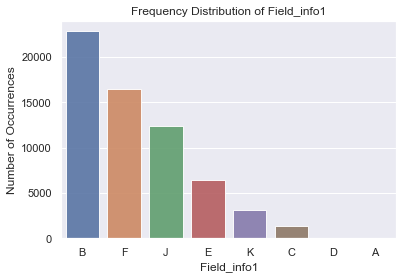

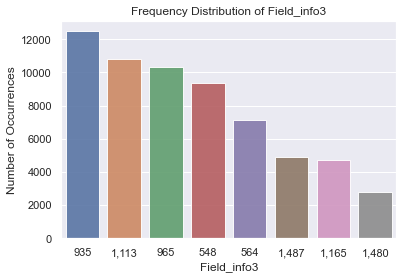

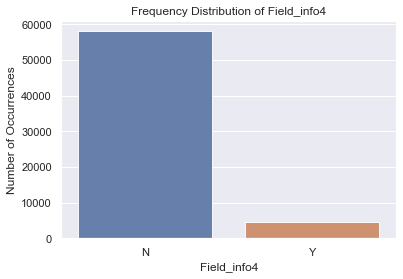

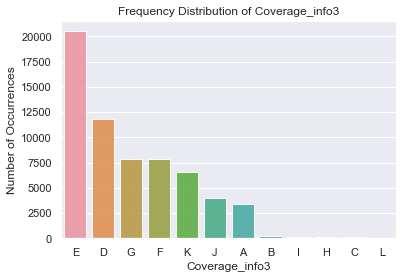

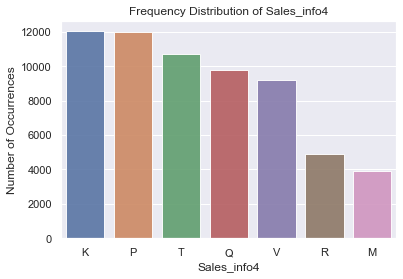

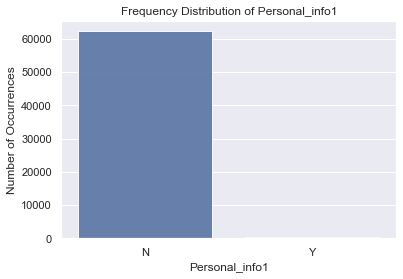

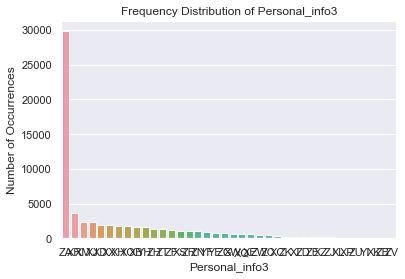

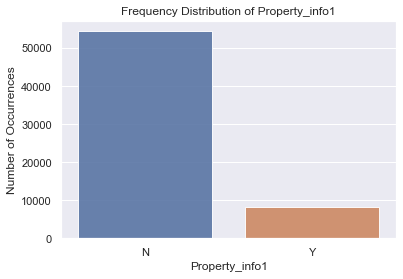

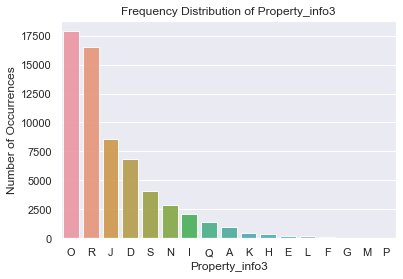

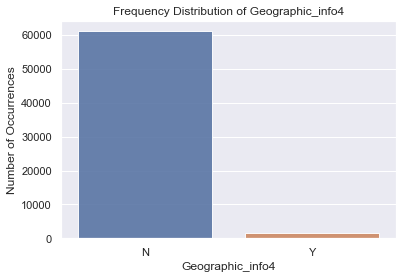

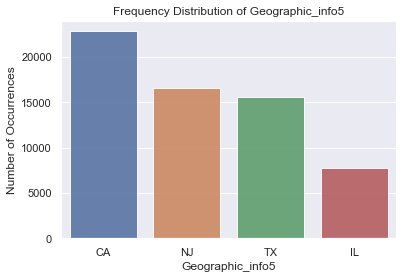

In [344]:
# plot_freuecncy_distrubuation(cat_df_train,'Quote_Date')
plot_freuecncy_distrubuation(cat_df_train,'Field_info1')
plot_freuecncy_distrubuation(cat_df_train,'Field_info3')
plot_freuecncy_distrubuation(cat_df_train,'Field_info4')
plot_freuecncy_distrubuation(cat_df_train,'Coverage_info3')
plot_freuecncy_distrubuation(cat_df_train,'Sales_info4')
plot_freuecncy_distrubuation(cat_df_train,'Personal_info1')
plot_freuecncy_distrubuation(cat_df_train,'Personal_info3')
plot_freuecncy_distrubuation(cat_df_train,'Property_info1')
plot_freuecncy_distrubuation(cat_df_train,'Property_info3')
plot_freuecncy_distrubuation(cat_df_train,'Geographic_info4')
plot_freuecncy_distrubuation(cat_df_train,'Geographic_info5')

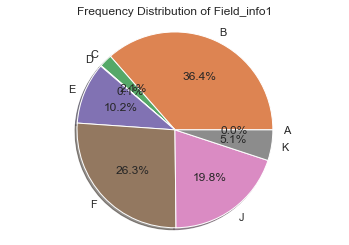

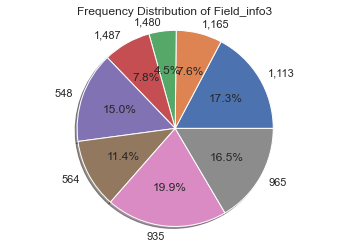

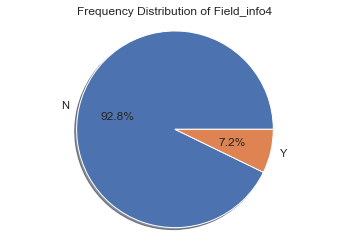

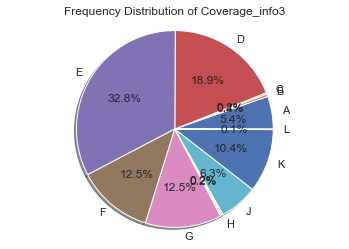

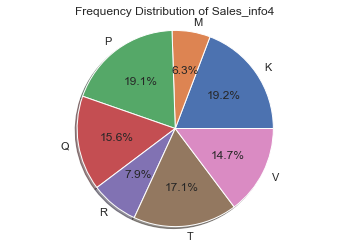

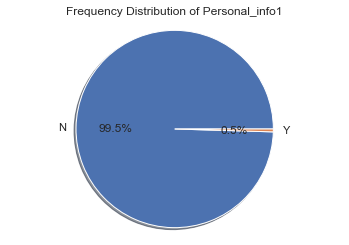

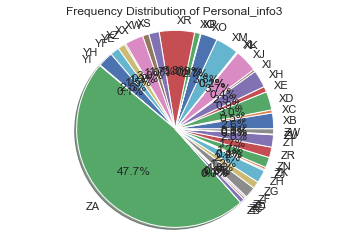

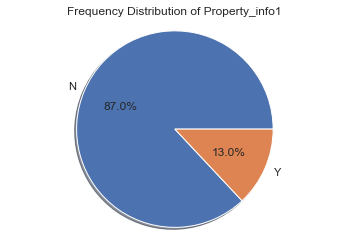

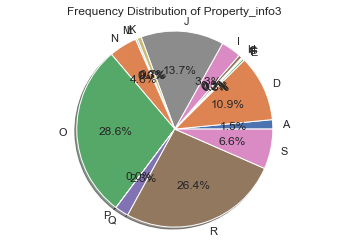

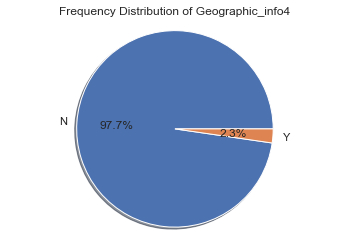

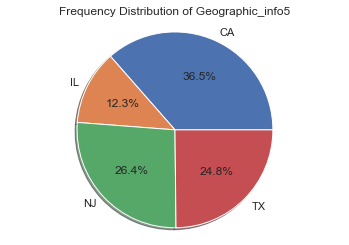

In [345]:
# plot_freuecncy_distrubuation_pie(cat_df_train,'Quote_Date')
plot_freuecncy_distrubuation_pie(cat_df_train,'Field_info1')
plot_freuecncy_distrubuation_pie(cat_df_train,'Field_info3')
plot_freuecncy_distrubuation_pie(cat_df_train,'Field_info4')
plot_freuecncy_distrubuation_pie(cat_df_train,'Coverage_info3')
plot_freuecncy_distrubuation_pie(cat_df_train,'Sales_info4')
plot_freuecncy_distrubuation_pie(cat_df_train,'Personal_info1')
plot_freuecncy_distrubuation_pie(cat_df_train,'Personal_info3')
plot_freuecncy_distrubuation_pie(cat_df_train,'Property_info1')
plot_freuecncy_distrubuation_pie(cat_df_train,'Property_info3')
plot_freuecncy_distrubuation_pie(cat_df_train,'Geographic_info4')
plot_freuecncy_distrubuation_pie(cat_df_train,'Geographic_info5')

In [346]:
cat_df_train_lc = cat_df_train.copy()
cat_df_train_lc['Quote_Date'] = cat_df_train_lc['Quote_Date'].astype('category')
cat_df_train_lc['Field_info1'] = cat_df_train_lc['Field_info1'].astype('category')
cat_df_train_lc['Field_info3'] = cat_df_train_lc['Field_info3'].astype('category')
cat_df_train_lc['Field_info4'] = cat_df_train_lc['Field_info4'].astype('category')
cat_df_train_lc['Coverage_info3'] = cat_df_train_lc['Coverage_info3'].astype('category')
cat_df_train_lc['Sales_info4'] = cat_df_train_lc['Sales_info4'].astype('category')
cat_df_train_lc['Personal_info1'] = cat_df_train_lc['Personal_info1'].astype('category')
cat_df_train_lc['Personal_info3'] = cat_df_train_lc['Personal_info3'].astype('category')
cat_df_train_lc['Property_info1'] = cat_df_train_lc['Property_info1'].astype('category')
cat_df_train_lc['Property_info3'] = cat_df_train_lc['Property_info3'].astype('category')
cat_df_train_lc['Geographic_info4'] = cat_df_train_lc['Geographic_info4'].astype('category')
cat_df_train_lc['Geographic_info5'] = cat_df_train_lc['Geographic_info5'].astype('category')
print(cat_df_train_lc.dtypes)

Quote_Date          category
Field_info1         category
Field_info3         category
Field_info4         category
Coverage_info3      category
Sales_info4         category
Personal_info1      category
Personal_info3      category
Property_info1      category
Property_info3      category
Geographic_info4    category
Geographic_info5    category
dtype: object


In [347]:
cat_df_train_lc['Quote_Date'] = cat_df_train_lc['Quote_Date'].cat.codes 
cat_df_train_lc['Field_info1'] = cat_df_train_lc['Field_info1'].cat.codes 
cat_df_train_lc['Field_info3'] = cat_df_train_lc['Field_info3'].cat.codes 
cat_df_train_lc['Field_info4'] = cat_df_train_lc['Field_info4'].cat.codes 
cat_df_train_lc['Coverage_info3'] = cat_df_train_lc['Coverage_info3'].cat.codes 
cat_df_train_lc['Sales_info4'] = cat_df_train_lc['Sales_info4'].cat.codes 
cat_df_train_lc['Personal_info1'] = cat_df_train_lc['Personal_info1'].cat.codes 
cat_df_train_lc['Personal_info3'] = cat_df_train_lc['Personal_info3'].cat.codes 
cat_df_train_lc['Property_info1'] = cat_df_train_lc['Property_info1'].cat.codes 
cat_df_train_lc['Property_info3'] = cat_df_train_lc['Property_info3'].cat.codes
cat_df_train_lc['Geographic_info4'] = cat_df_train_lc['Geographic_info4'].cat.codes 
cat_df_train_lc['Geographic_info5'] = cat_df_train_lc['Geographic_info5'].cat.codes 
print(cat_df_train_lc['Field_info1'].value_counts())
cat_df_train_lc.head()

1    22809
5    16444
6    12371
4     6375
7     3166
2     1342
3       63
0       10
Name: Field_info1, dtype: int64


,Quote_Date,Field_info1,Field_info3,Field_info4,Coverage_info3,Sales_info4,Personal_info1,Personal_info3,Property_info1,Property_info3,Geographic_info4,Geographic_info5
0,164,1,6,0,3,5,0,22,0,1,0,0
1,310,6,1,0,5,2,0,13,0,1,0,3
2,763,1,6,0,3,6,0,22,0,1,0,0
3,178,6,0,0,5,3,0,22,0,12,0,3
4,664,5,4,0,4,0,0,2,0,15,0,2


In [348]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62580 entries, 0 to 62579
Data columns (total 30 columns):
Quote_Id            62580 non-null int64
Quote_Date          62580 non-null object
Quote_Flag          62580 non-null int64
Field_info1         62580 non-null object
Field_info2         62580 non-null float64
Field_info3         62580 non-null object
Field_info4         62580 non-null object
Coverage_info1      62580 non-null int64
Coverage_info2      62580 non-null int64
Coverage_info3      62580 non-null object
Sales_info1         62580 non-null int64
Sales_info2         62580 non-null int64
Sales_info3         62580 non-null int64
Sales_info4         62580 non-null object
Sales_info5         62580 non-null int64
Personal_info1      62557 non-null object
Personal_info2      62580 non-null int64
Personal_info3      62580 non-null object
Personal_info4      62580 non-null int64
Personal_info5      32792 non-null float64
Property_info1      62564 non-null object
Property_info2   

In [349]:
cat_df_train_lc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62580 entries, 0 to 62579
Data columns (total 12 columns):
Quote_Date          62580 non-null int16
Field_info1         62580 non-null int8
Field_info3         62580 non-null int8
Field_info4         62580 non-null int8
Coverage_info3      62580 non-null int8
Sales_info4         62580 non-null int8
Personal_info1      62580 non-null int8
Personal_info3      62580 non-null int8
Property_info1      62580 non-null int8
Property_info3      62580 non-null int8
Geographic_info4    62580 non-null int8
Geographic_info5    62580 non-null int8
dtypes: int16(1), int8(11)
memory usage: 794.6 KB


In [350]:
train_preprocessed=train.drop(['Quote_Id','Quote_Date','Field_info1','Field_info3','Field_info4',
                 'Coverage_info3','Sales_info4','Personal_info1','Personal_info3','Property_info1',
                 'Property_info3','Geographic_info4','Geographic_info5'], axis=1)
train_preprocessed.shape

(62580, 17)

In [351]:
train_numeric_features = train.select_dtypes('number')
train_numeric_features = train_numeric_features.drop(['Quote_Id'], axis=1)
train_numeric_features.shape
print("Total Null in Numeric Train Featuers-----------------:",train_numeric_features.isnull().values.sum())
print("column-wise distribution of null values----:\n\n",train_numeric_features.isnull().sum())
train_numeric_features.info
print(train_numeric_features.describe())


Total Null in Numeric Train Featuers-----------------: 29788
column-wise distribution of null values----:

 Quote_Flag              0
Field_info2             0
Coverage_info1          0
Coverage_info2          0
Sales_info1             0
Sales_info2             0
Sales_info3             0
Sales_info5             0
Personal_info2          0
Personal_info4          0
Personal_info5      29788
Property_info2          0
Property_info4          0
Property_info5          0
Geographic_info1        0
Geographic_info2        0
Geographic_info3        0
dtype: int64
         Quote_Flag   Field_info2  Coverage_info1  Coverage_info2  \
count  62580.000000  62580.000000    62580.000000    62580.000000   
mean       0.191035      0.938307        8.999057       21.197779   
std        0.393120      0.037030        5.575434        4.926863   
min        0.000000      0.874600       -1.000000        1.000000   
25%        0.000000      0.915300        5.000000       22.000000   
50%        0.000000    

In [352]:
result_df1 = pd.concat([train_numeric_features, cat_df_train_lc], axis=1)
result_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62580 entries, 0 to 62579
Data columns (total 29 columns):
Quote_Flag          62580 non-null int64
Field_info2         62580 non-null float64
Coverage_info1      62580 non-null int64
Coverage_info2      62580 non-null int64
Sales_info1         62580 non-null int64
Sales_info2         62580 non-null int64
Sales_info3         62580 non-null int64
Sales_info5         62580 non-null int64
Personal_info2      62580 non-null int64
Personal_info4      62580 non-null int64
Personal_info5      32792 non-null float64
Property_info2      62580 non-null int64
Property_info4      62580 non-null int64
Property_info5      62580 non-null int64
Geographic_info1    62580 non-null int64
Geographic_info2    62580 non-null int64
Geographic_info3    62580 non-null int64
Quote_Date          62580 non-null int16
Field_info1         62580 non-null int8
Field_info3         62580 non-null int8
Field_info4         62580 non-null int8
Coverage_info3      62580 non

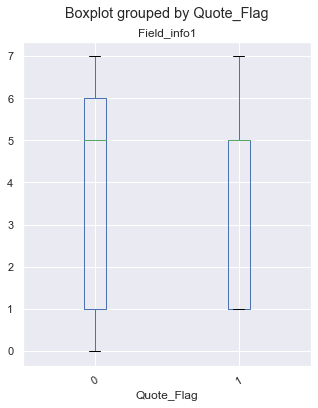

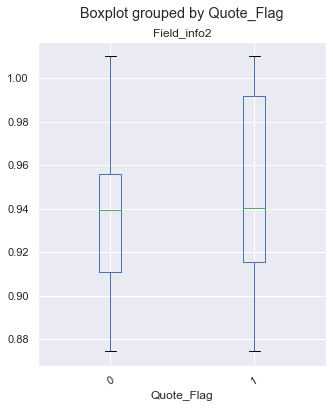

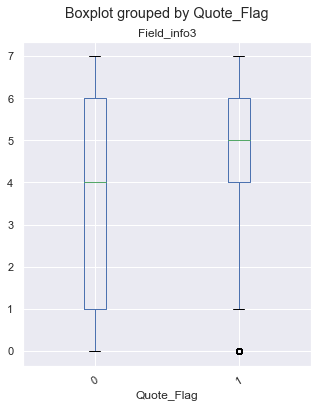

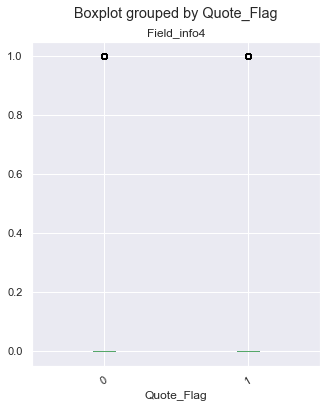

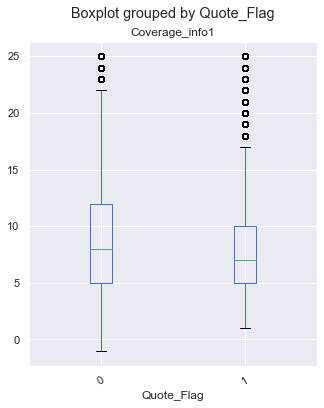

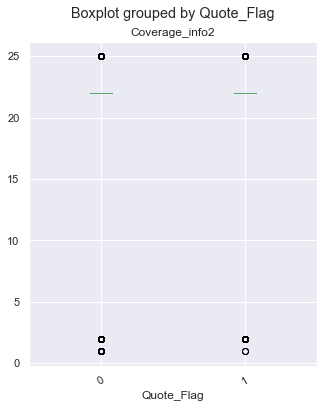

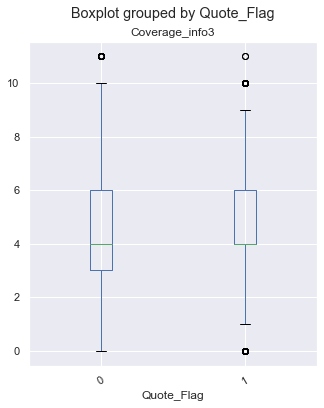

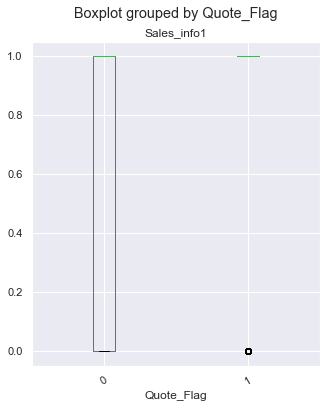

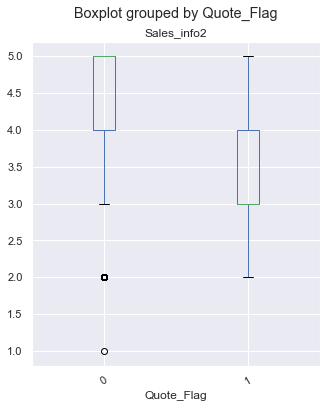

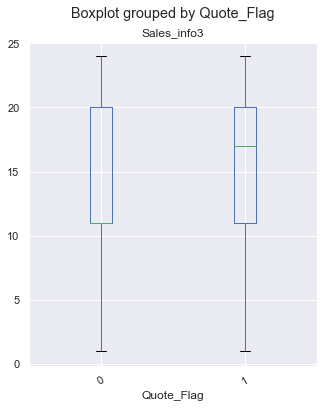

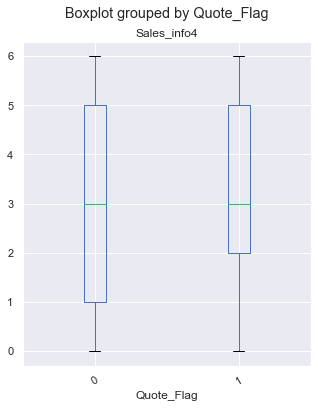

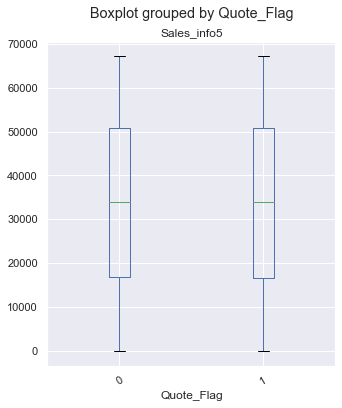

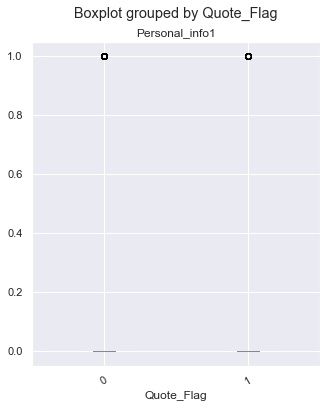

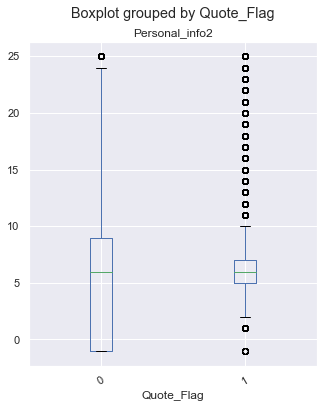

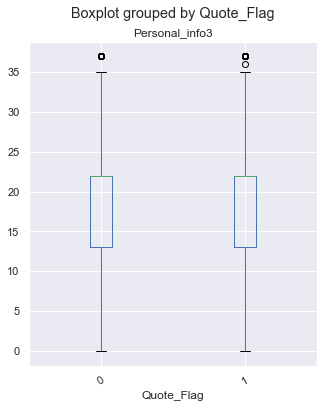

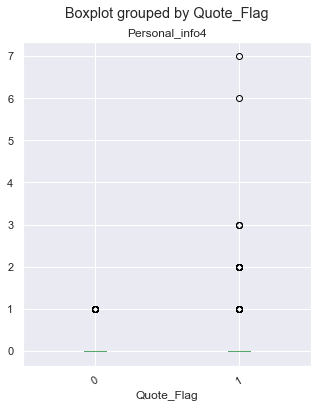

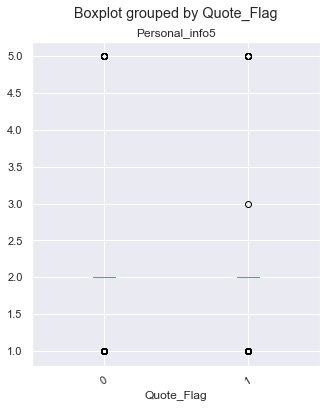

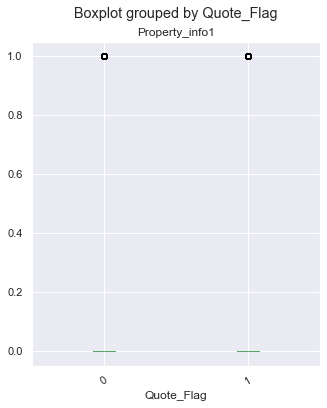

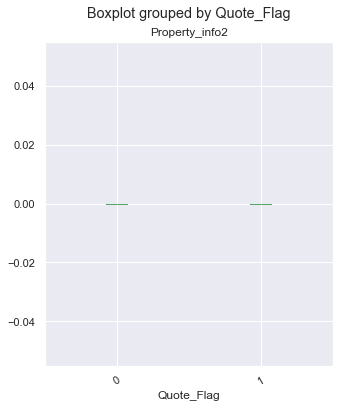

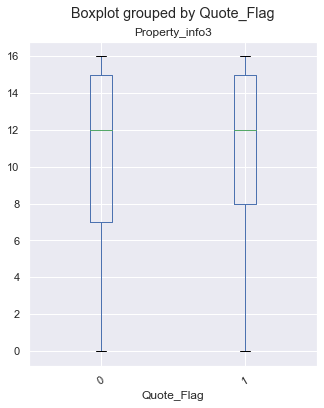

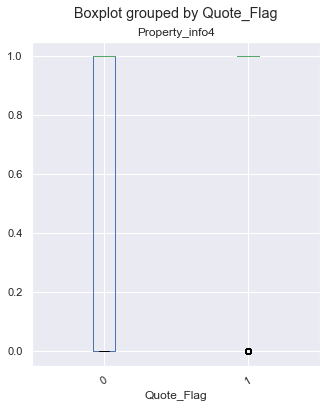

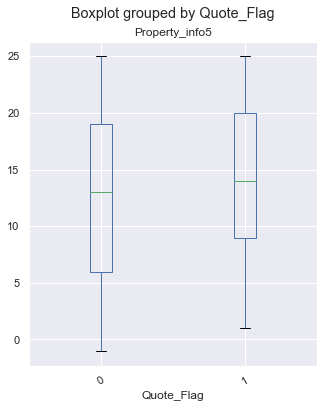

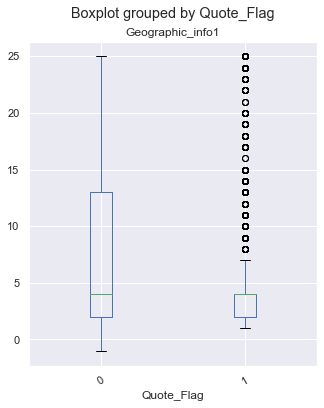

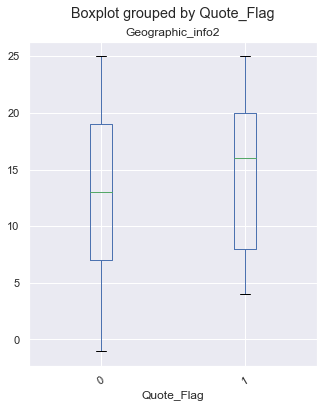

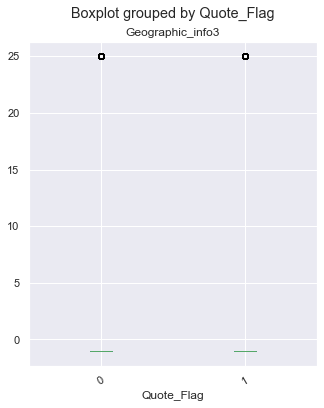

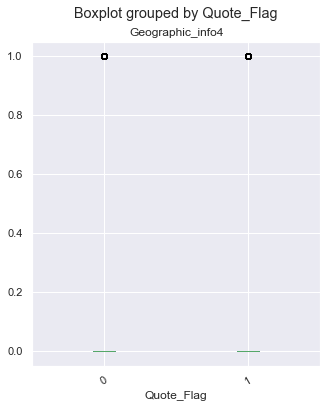

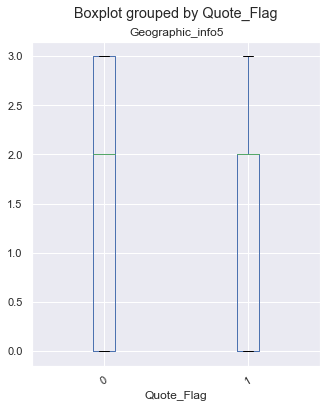

In [353]:
result_df1.boxplot('Field_info1','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Field_info2','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Field_info3','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Field_info4','Quote_Flag',rot = 30,figsize=(5,6))

result_df1.boxplot('Coverage_info1','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Coverage_info2','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Coverage_info3','Quote_Flag',rot = 30,figsize=(5,6))

result_df1.boxplot('Sales_info1','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Sales_info2','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Sales_info3','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Sales_info4','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Sales_info5','Quote_Flag',rot = 30,figsize=(5,6))

result_df1.boxplot('Personal_info1','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Personal_info2','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Personal_info3','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Personal_info4','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Personal_info5','Quote_Flag',rot = 30,figsize=(5,6))

result_df1.boxplot('Property_info1','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Property_info2','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Property_info3','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Property_info4','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Property_info5','Quote_Flag',rot = 30,figsize=(5,6))

result_df1.boxplot('Geographic_info1','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Geographic_info2','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Geographic_info3','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Geographic_info4','Quote_Flag',rot = 30,figsize=(5,6))
result_df1.boxplot('Geographic_info5','Quote_Flag',rot = 30,figsize=(5,6))
warnings.filterwarnings("ignore")


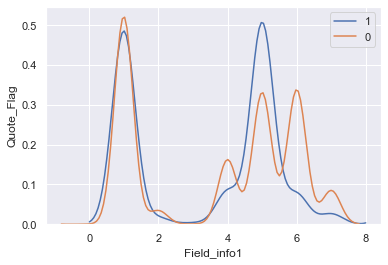

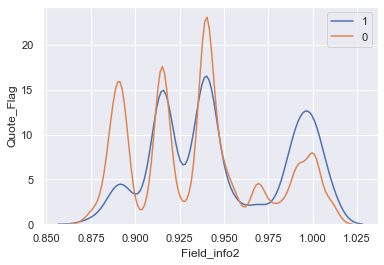

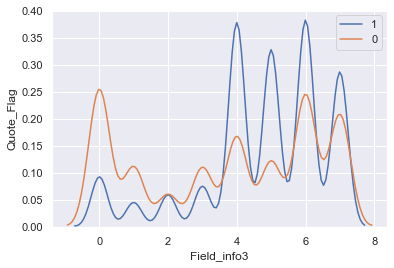

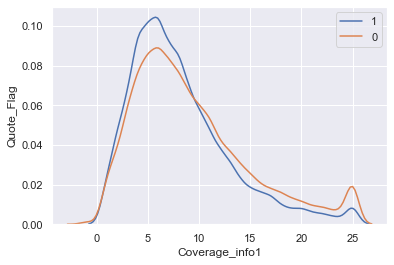

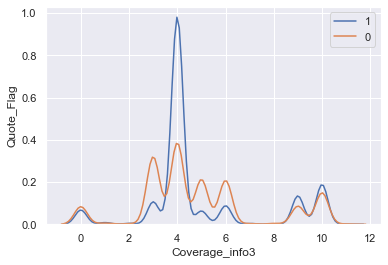

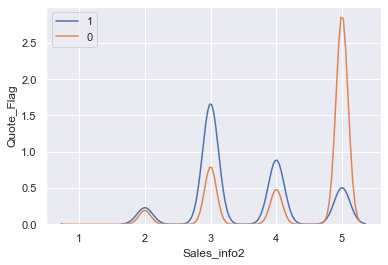

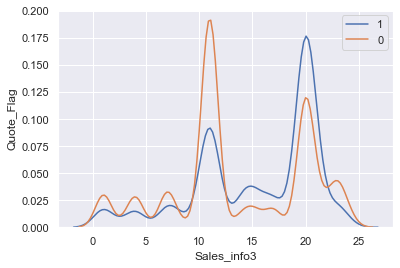

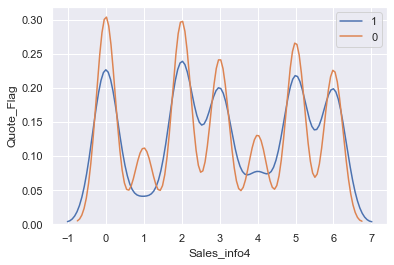

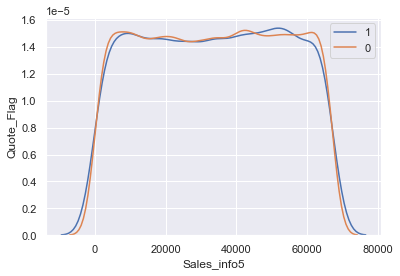

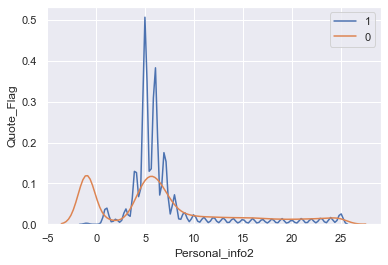

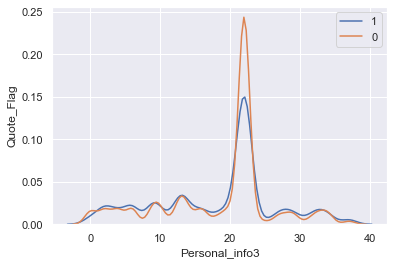

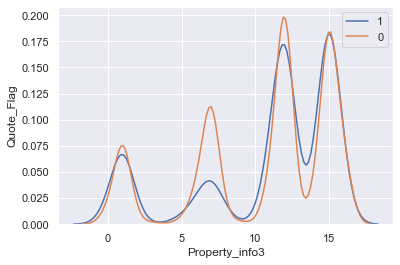

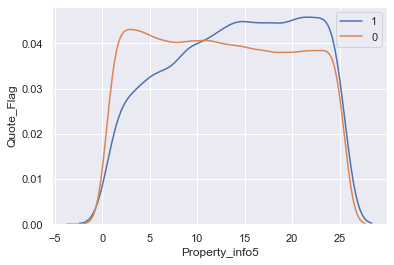

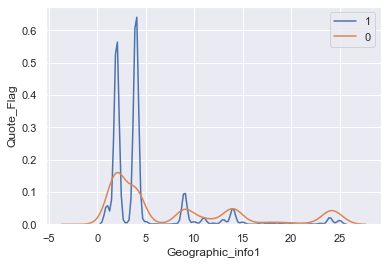

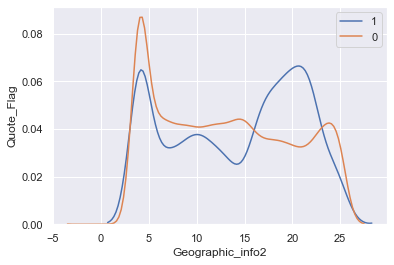

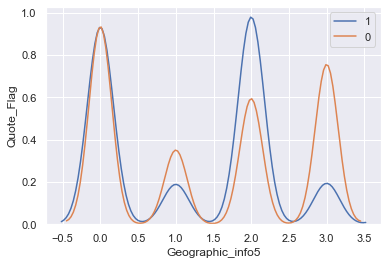

In [354]:
# df = pd.DataFrame({"cls": classes, "indices":idx, "vals": vals})

sns.kdeplot(result_df1.Field_info1[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Field_info1[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Field_info1')
plt.ylabel('Quote_Flag')
plt.show()

sns.kdeplot(result_df1.Field_info2[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Field_info2[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Field_info2')
plt.ylabel('Quote_Flag')
plt.show()

sns.kdeplot(result_df1.Field_info3[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Field_info3[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Field_info3')
plt.ylabel('Quote_Flag')
plt.show()



sns.kdeplot(result_df1.Coverage_info1[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Coverage_info1[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Coverage_info1')
plt.ylabel('Quote_Flag')
plt.show()


# sns.kdeplot(result_df1.Coverage_info2[result_df1.Quote_Flag == 1],label='1');
# sns.kdeplot(result_df1.Coverage_info2[result_df1.Quote_Flag == 0],label='0');
# # beautifying the labels
# plt.xlabel('Coverage_info2')
# plt.ylabel('Quote_Flag')
# plt.show()


sns.kdeplot(result_df1.Coverage_info3[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Coverage_info3[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Coverage_info3')
plt.ylabel('Quote_Flag')
plt.show()

# sns.kdeplot(result_df1.Sales_info1[result_df1.Quote_Flag == 1],label='1');
# sns.kdeplot(result_df1.Sales_info1[result_df1.Quote_Flag == 0],label='0');
# # beautifying the labels
# plt.xlabel('Sales_info1')
# plt.ylabel('Quote_Flag')
# plt.show()

sns.kdeplot(result_df1.Sales_info2[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Sales_info2[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Sales_info2')
plt.ylabel('Quote_Flag')
plt.show()

sns.kdeplot(result_df1.Sales_info3[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Sales_info3[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Sales_info3')
plt.ylabel('Quote_Flag')
plt.show()

sns.kdeplot(result_df1.Sales_info4[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Sales_info4[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Sales_info4')
plt.ylabel('Quote_Flag')
plt.show()

sns.kdeplot(result_df1.Sales_info5[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Sales_info5[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Sales_info5')
plt.ylabel('Quote_Flag')
plt.show()

sns.kdeplot(result_df1.Personal_info2[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Personal_info2[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Personal_info2')
plt.ylabel('Quote_Flag')
plt.show()


sns.kdeplot(result_df1.Personal_info3[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Personal_info3[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Personal_info3')
plt.ylabel('Quote_Flag')
plt.show()


# sns.kdeplot(result_df1.Personal_info5[result_df1.Quote_Flag == 1],label='1');
# sns.kdeplot(result_df1.Personal_info5[result_df1.Quote_Flag == 0],label='0');
# # beautifying the labels
# plt.xlabel('Personal_info5')
# plt.ylabel('Quote_Flag')
# plt.show()

# sns.kdeplot(result_df1.Property_info2[result_df1.Quote_Flag == 1],label='1');
# sns.kdeplot(result_df1.Property_info2[result_df1.Quote_Flag == 0],label='0');
# # beautifying the labels
# plt.xlabel('Property_info2')
# plt.ylabel('Quote_Flag')
# plt.show()

sns.kdeplot(result_df1.Property_info3[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Property_info3[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Property_info3')
plt.ylabel('Quote_Flag')
plt.show()

# sns.kdeplot(result_df1.Property_info4[result_df1.Quote_Flag == 1],label='1');
# sns.kdeplot(result_df1.Property_info4[result_df1.Quote_Flag == 0],label='0');
# # beautifying the labels
# plt.xlabel('Property_info4')
# plt.ylabel('Quote_Flag')
# plt.show()

# sns.kdeplot(result_df1.Property_info4[result_df1.Quote_Flag == 1],label='1');
# sns.kdeplot(result_df1.Property_info4[result_df1.Quote_Flag == 0],label='0');
# # beautifying the labels
# plt.xlabel('Property_info4')
# plt.ylabel('Quote_Flag')
# plt.show()

sns.kdeplot(result_df1.Property_info5[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Property_info5[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Property_info5')
plt.ylabel('Quote_Flag')
plt.show()

# this is to plot the kde
sns.kdeplot(result_df1.Geographic_info1[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Geographic_info1[result_df1.Quote_Flag == 0],label='0');
# beautifying the labels
plt.xlabel('Geographic_info1')
plt.ylabel('Quote_Flag')
plt.show()
sns.kdeplot(result_df1.Geographic_info2[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Geographic_info2[result_df1.Quote_Flag == 0],label='0');
plt.xlabel('Geographic_info2')
plt.ylabel('Quote_Flag')
plt.show()

# sns.kdeplot(result_df1.Geographic_info3[result_df1.Quote_Flag == 1],label='1');
# sns.kdeplot(result_df1.Geographic_info3[result_df1.Quote_Flag == 0],label='0');
# plt.xlabel('Geographic_info3')
# plt.ylabel('Quote_Flag')
# plt.show()

# sns.kdeplot(result_df1.Geographic_info4[result_df1.Quote_Flag == 1],label='1');
# sns.kdeplot(result_df1.Geographic_info4[result_df1.Quote_Flag == 0],label='0');
# plt.xlabel('Geographic_info4')
# plt.ylabel('Quote_Flag')
# plt.show()
sns.kdeplot(result_df1.Geographic_info5[result_df1.Quote_Flag == 1],label='1');
sns.kdeplot(result_df1.Geographic_info5[result_df1.Quote_Flag == 0],label='0');
plt.xlabel('Geographic_info5')
plt.ylabel('Quote_Flag')
plt.show()

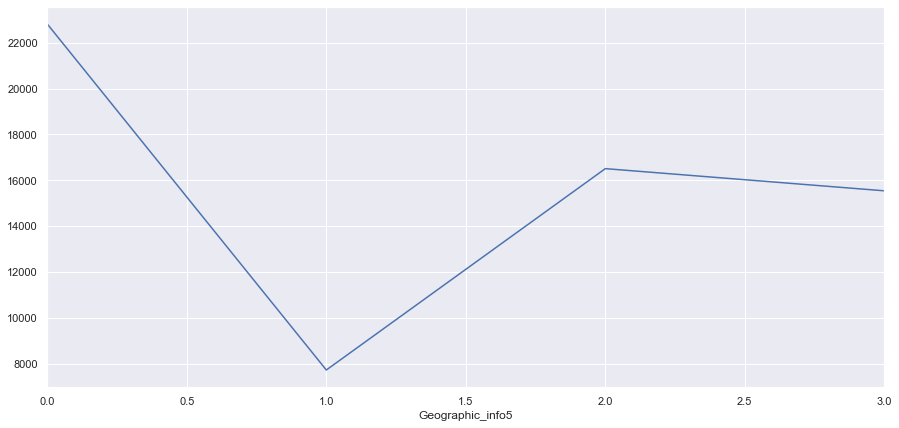

In [355]:
fig, ax = plt.subplots(figsize=(15,7))
result_df1.groupby(['Geographic_info5']).count()['Quote_Flag'].plot(ax=ax)

In [356]:
print("Total Null in All Featuers-----------------:",result_df1.isnull().values.sum())
print("column-wise distribution of null values----:\n\n",result_df1.isnull().sum())

Total Null in All Featuers-----------------: 29788
column-wise distribution of null values----:

 Quote_Flag              0
Field_info2             0
Coverage_info1          0
Coverage_info2          0
Sales_info1             0
Sales_info2             0
Sales_info3             0
Sales_info5             0
Personal_info2          0
Personal_info4          0
Personal_info5      29788
Property_info2          0
Property_info4          0
Property_info5          0
Geographic_info1        0
Geographic_info2        0
Geographic_info3        0
Quote_Date              0
Field_info1             0
Field_info3             0
Field_info4             0
Coverage_info3          0
Sales_info4             0
Personal_info1          0
Personal_info3          0
Property_info1          0
Property_info3          0
Geographic_info4        0
Geographic_info5        0
dtype: int64


In [357]:
result_df1 = result_df1.fillna(result_df1['Property_info2'].value_counts().index[0])
print("column-wise distribution of null values:\n",result_df1.isnull().sum())

column-wise distribution of null values:
 Quote_Flag          0
Field_info2         0
Coverage_info1      0
Coverage_info2      0
Sales_info1         0
Sales_info2         0
Sales_info3         0
Sales_info5         0
Personal_info2      0
Personal_info4      0
Personal_info5      0
Property_info2      0
Property_info4      0
Property_info5      0
Geographic_info1    0
Geographic_info2    0
Geographic_info3    0
Quote_Date          0
Field_info1         0
Field_info3         0
Field_info4         0
Coverage_info3      0
Sales_info4         0
Personal_info1      0
Personal_info3      0
Property_info1      0
Property_info3      0
Geographic_info4    0
Geographic_info5    0
dtype: int64


In [358]:
#To show heatmap data should be in matrix form.
tc = result_df1.corr()   #shows corelation in matrix form
tc

,Quote_Flag,Field_info2,Coverage_info1,Coverage_info2,Sales_info1,Sales_info2,Sales_info3,Sales_info5,Personal_info2,Personal_info4,...,Field_info3,Field_info4,Coverage_info3,Sales_info4,Personal_info1,Personal_info3,Property_info1,Property_info3,Geographic_info4,Geographic_info5
Quote_Flag,1.000000,0.138347,-0.077228,0.036405,0.105319,-0.355711,0.114128,-0.000231,0.025298,0.029890,...,0.164187,-0.069048,0.017297,0.028235,-0.005835,-0.012844,0.019307,0.028932,-0.013119,-0.082769
Field_info2,0.138347,1.000000,-0.018839,0.075957,-0.013172,-0.163974,0.067438,0.006337,-0.012763,0.001511,...,0.278012,-0.366583,-0.040840,0.008647,-0.002405,-0.069429,0.011353,0.167948,-0.022751,0.026653
Coverage_info1,-0.077228,-0.018839,1.000000,0.072399,-0.029470,0.039114,0.021387,0.007728,0.006631,-0.000419,...,0.060247,-0.012745,-0.224386,-0.006696,0.014227,0.039240,0.170053,0.020289,0.017808,-0.057164
Coverage_info2,0.036405,0.075957,0.072399,1.000000,0.038722,-0.070765,0.024003,-0.000711,0.042266,0.003731,...,0.072200,-0.037428,-0.051250,-0.004523,0.006294,0.015890,0.040955,0.019792,-0.004549,-0.029701
Sales_info1,0.105319,-0.013172,-0.029470,0.038722,1.000000,-0.130286,-0.019894,0.002624,0.147599,-0.004877,...,-0.082927,0.063060,0.055965,0.004510,0.009790,-0.031520,-0.001197,0.024488,-0.007163,0.073720
Sales_info2,-0.355711,-0.163974,0.039114,-0.070765,-0.130286,1.000000,-0.347010,-0.005164,-0.010158,-0.018852,...,-0.215062,0.115266,-0.075697,-0.034753,0.006174,0.037486,-0.027171,-0.050481,0.025877,0.126988
Sales_info3,0.114128,0.067438,0.021387,0.024003,-0.019894,-0.347010,1.000000,0.004032,0.003212,0.007984,...,0.220300,-0.085714,-0.008255,0.013279,-0.000476,0.021977,0.011095,0.028115,-0.003256,-0.166118
Sales_info5,-0.000231,0.006337,0.007728,-0.000711,0.002624,-0.005164,0.004032,1.000000,-0.003562,-0.002564,...,0.010522,-0.003634,-0.007649,-0.003286,-0.000017,0.004163,-0.000775,0.000068,-0.002698,-0.008841
Personal_info2,0.025298,-0.012763,0.006631,0.042266,0.147599,-0.010158,0.003212,-0.003562,1.000000,0.001490,...,-0.048112,0.046569,0.019158,-0.004331,0.016265,0.001809,0.036309,0.024468,-0.065052,0.037631
Personal_info4,0.029890,0.001511,-0.000419,0.003731,-0.004877,-0.018852,0.007984,-0.002564,0.001490,1.000000,...,0.010234,-0.006077,0.001765,0.005466,-0.001493,0.006240,-0.000549,-0.000092,-0.003343,-0.007620


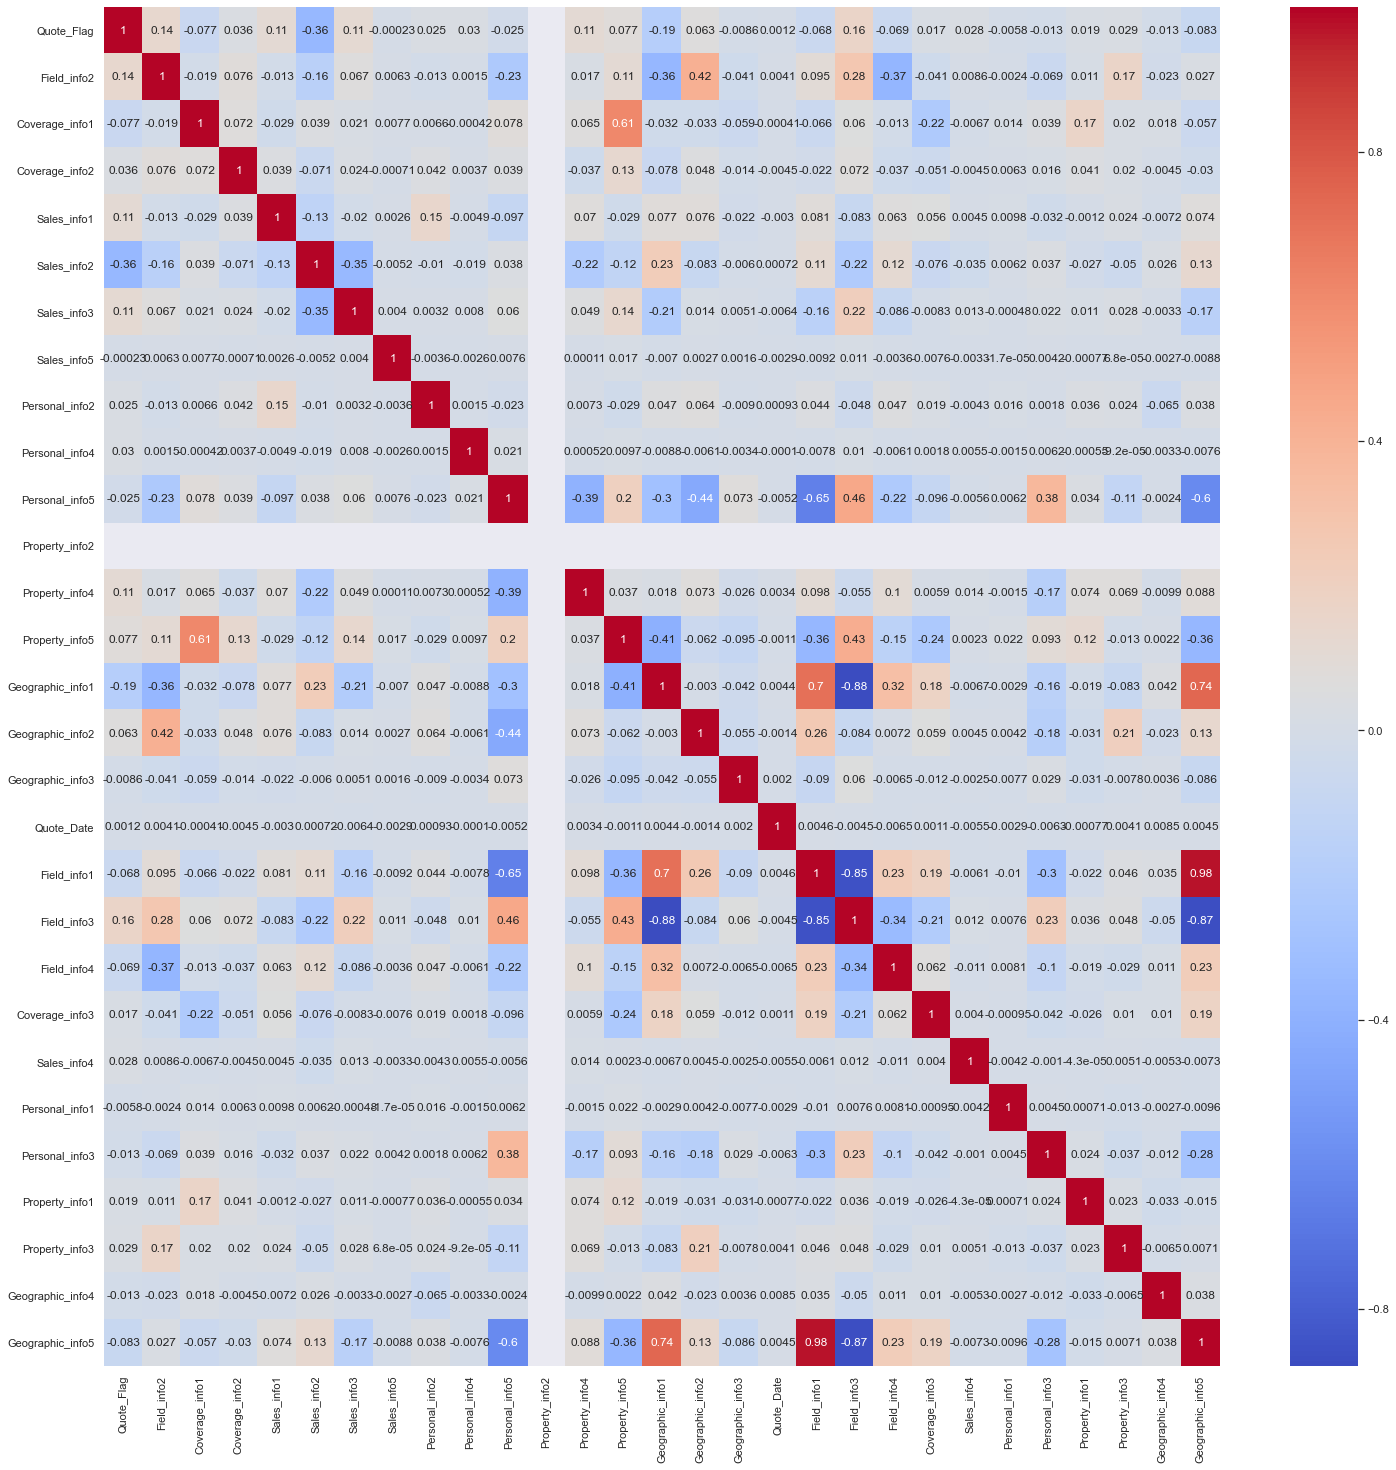

In [359]:
plt.figure(figsize = (25,25))
sns.heatmap(tc, annot=True, cmap='coolwarm')
# plt.savefig('corelation.png')

In [299]:
# result_df1 = result_df1.sample(n=62580).reset_index(drop=True)

#  Applyig all steps on Unknow Data

In [360]:
# Combining Lebels with Test Data and Preporcessing
# y_lables = y_labels.drop(['Quote_Id'], axis=1)
# print(y_lables.shape)
# test = pd.concat([test, y_lables], axis=1)
cat_df_UnknowData = UnknowData.select_dtypes(include=['object']).copy()
print(cat_df_UnknowData.shape)
print("Total Null in categorical Featuers of UnknowData",cat_df_UnknowData.isnull().values.sum())
print("column-wise distribution of null values in UnknowedData:\n",cat_df_UnknowData.isnull().sum())
cat_df_UnknowData = cat_df_UnknowData.fillna(cat_df_UnknowData['Personal_info1'].value_counts().index[0])
# print("column-wise distribution of null values in Test Data:\n",cat_df_test.isnull().sum())
# print("Unique Categories in Field_info1-------: ",cat_df_test['Field_info1'].value_counts().count())
# print("Unique Categories in Field_info3-------: ",cat_df_test['Field_info3'].value_counts().count())
# print("Unique Categories in Field_info4-------: ",cat_df_test['Field_info4'].value_counts().count())
# print("Unique Categories in Coverage_info3----: ",cat_df_test['Coverage_info3'].value_counts().count())
# print("Unique Categories in Sales_info4-------: ",cat_df_test['Sales_info4'].value_counts().count())
# print("Unique Categories in Personal_info1----: ",cat_df_test['Personal_info1'].value_counts().count())
# print("Unique Categories in Personal_info3----: ",cat_df_test['Personal_info3'].value_counts().count())
# print("Unique Categories in Property_info1----: ",cat_df_test['Property_info1'].value_counts().count())
# print("Unique Categories in Property_info3----: ",cat_df_test['Property_info3'].value_counts().count())
# print("Unique Categories in Geographic_info4--: ",cat_df_test['Geographic_info4'].value_counts().count())
# print("Unique Categories in Geographic_info5--: ",cat_df_test['Geographic_info5'].value_counts().count())

cat_df_UnknowData_lc = cat_df_test.copy()
cat_df_UnknowData_lc['Quote_Date'] = cat_df_UnknowData_lc['Quote_Date'].astype('category')
cat_df_UnknowData_lc['Field_info1'] = cat_df_UnknowData_lc['Field_info1'].astype('category')
cat_df_UnknowData_lc['Field_info3'] = cat_df_UnknowData_lc['Field_info3'].astype('category')
cat_df_UnknowData_lc['Field_info4'] = cat_df_UnknowData_lc['Field_info4'].astype('category')
cat_df_UnknowData_lc['Coverage_info3'] = cat_df_UnknowData_lc['Coverage_info3'].astype('category')
cat_df_UnknowData_lc['Sales_info4'] = cat_df_UnknowData_lc['Sales_info4'].astype('category')
cat_df_UnknowData_lc['Personal_info1'] = cat_df_UnknowData_lc['Personal_info1'].astype('category')
cat_df_UnknowData_lc['Personal_info3'] = cat_df_UnknowData_lc['Personal_info3'].astype('category')
cat_df_UnknowData_lc['Property_info1'] = cat_df_UnknowData_lc['Property_info1'].astype('category')
cat_df_UnknowData_lc['Property_info3'] = cat_df_UnknowData_lc['Property_info3'].astype('category')
cat_df_UnknowData_lc['Geographic_info4'] = cat_df_UnknowData_lc['Geographic_info4'].astype('category')
cat_df_UnknowData_lc['Geographic_info5'] = cat_df_UnknowData_lc['Geographic_info5'].astype('category')
print(cat_df_UnknowData_lc.dtypes)

cat_df_UnknowData_lc['Quote_Date'] = cat_df_UnknowData_lc['Quote_Date'].cat.codes 
cat_df_UnknowData_lc['Field_info1'] = cat_df_UnknowData_lc['Field_info1'].cat.codes 
cat_df_UnknowData_lc['Field_info3'] = cat_df_UnknowData_lc['Field_info3'].cat.codes 
cat_df_UnknowData_lc['Field_info4'] = cat_df_UnknowData_lc['Field_info4'].cat.codes 
cat_df_UnknowData_lc['Coverage_info3'] = cat_df_UnknowData_lc['Coverage_info3'].cat.codes 
cat_df_UnknowData_lc['Sales_info4'] = cat_df_UnknowData_lc['Sales_info4'].cat.codes 
cat_df_UnknowData_lc['Personal_info1'] = cat_df_UnknowData_lc['Personal_info1'].cat.codes 
cat_df_UnknowData_lc['Personal_info3'] = cat_df_UnknowData_lc['Personal_info3'].cat.codes 
cat_df_UnknowData_lc['Property_info1'] = cat_df_UnknowData_lc['Property_info1'].cat.codes 
cat_df_UnknowData_lc['Property_info3'] = cat_df_UnknowData_lc['Property_info3'].cat.codes
cat_df_UnknowData_lc['Geographic_info4'] = cat_df_UnknowData_lc['Geographic_info4'].cat.codes 
cat_df_UnknowData_lc['Geographic_info5'] = cat_df_UnknowData_lc['Geographic_info5'].cat.codes 

UnknowData_preprocessed=UnknowData.drop(['Quote_Id','Quote_Date','Field_info1','Field_info3','Field_info4',
                 'Coverage_info3','Sales_info4','Personal_info1','Personal_info3','Property_info1',
                 'Property_info3','Geographic_info4','Geographic_info5'], axis=1)
print(UnknowData_preprocessed.shape)
UnknowData_numeric_features = UnknowData.select_dtypes('number')
UnknowData_numeric_features = UnknowData_numeric_features.drop(['Quote_Id'], axis=1)
UnknowData_numeric_features.shape
print("Total Null in Numeric UnknowData Featuers-----------------:",UnknowData_numeric_features.isnull().values.sum())
print("column-wise distribution of null values----:\n\n",UnknowData_numeric_features.isnull().sum())

result_df2 = pd.concat([UnknowData_numeric_features, cat_df_UnknowData_lc], axis=1)
result_df2 = result_df2.fillna(result_df2['Property_info2'].value_counts().index[0])
result_df2.head()

(41721, 12)
Total Null in categorical Featuers of UnknowData 38
column-wise distribution of null values in UnknowedData:
 Quote_Date           0
Field_info1          0
Field_info3          0
Field_info4          0
Coverage_info3       0
Sales_info4          0
Personal_info1      23
Personal_info3       0
Property_info1      15
Property_info3       0
Geographic_info4     0
Geographic_info5     0
dtype: int64
Quote_Date          category
Field_info1         category
Field_info3         category
Field_info4         category
Coverage_info3      category
Sales_info4         category
Personal_info1      category
Personal_info3      category
Property_info1      category
Property_info3      category
Geographic_info4    category
Geographic_info5    category
dtype: object
(41721, 16)
Total Null in Numeric UnknowData Featuers-----------------: 19724
column-wise distribution of null values----:

 Field_info2             0
Coverage_info1          0
Coverage_info2          0
Sales_info1             

,Field_info2,Coverage_info1,Coverage_info2,Sales_info1,Sales_info2,Sales_info3,Sales_info5,Personal_info2,Personal_info4,Personal_info5,...,Field_info3,Field_info4,Coverage_info3,Sales_info4,Personal_info1,Personal_info3,Property_info1,Property_info3,Geographic_info4,Geographic_info5
0,0.9472,8,22,1,5,7,12505,5,0,2.0,...,3,0,5,4,0,25,1,3,0,1
1,0.9919,11,22,0,2,17,59183,21,0,0.0,...,5,0,4,2,0,14,0,16,0,2
2,0.9403,4,22,0,3,20,61998,25,0,2.0,...,7,0,9,5,0,25,0,14,0,0
3,0.9153,12,22,1,5,11,46142,19,0,2.0,...,6,0,3,3,0,25,0,3,0,0
4,0.9485,5,22,1,5,1,27464,7,0,2.0,...,2,0,10,2,0,25,0,16,0,1


In [361]:
# dropping columns which are not relevant or similar columns.

X = result_df1.drop(['Quote_Flag',
#                            'Field_info1',
#                            'Field_info2',
#                            'Field_info3',
#                            'Field_info4',
#                            'Coverage_info2',
#                            'Coverage_info1',
#                            'Coverage_info3',
#                      'Sales_info1',
#                            'Sales_info2',
#                            'Sales_info3',
#                            'Sales_info4',
#                            'Sales_info5',
#                      'Personal_info1',
#                            'Personal_info2',
#                            'Personal_info3',
#                            'Personal_info4',
#                            'Personal_info5',
#                      'Property_info1',
#                            'Property_info2',
#                            'Property_info3',
#                            'Property_info4','Property_info5',
#                         'Geographic_info1',
#                            'Geographic_info2',
#                            'Geographic_info3',
#                            'Geographic_info4',
#                            'Geographic_info5',
                     'Quote_Date'], axis=1)

y = result_df1['Quote_Flag']
X_UnknowData = result_df2.drop([
#     'Quote_Flag',
#                             'Field_info1',
#                            'Field_info2',
#                            'Field_info3',
#                            'Field_info4',
#                            'Coverage_info2',
#                            'Coverage_info1',
#                            'Coverage_info3',
#                      'Sales_info1',
#                            'Sales_info2',
#                            'Sales_info3',
#                            'Sales_info4',
#                            'Sales_info5',
#                      'Personal_info1',
#                            'Personal_info2','Personal_info3',
#                            'Personal_info4',
#                            'Personal_info5',
#                      'Property_info1',
#                            'Property_info2',
#                            'Property_info3','Property_info4','Property_info5',
#                         'Geographic_info1',
#                            'Geographic_info2',
#                            'Geographic_info3',
#                            'Geographic_info4',
#                            'Geographic_info5',
                     'Quote_Date' ], axis=1)
# y_test = result_df2['Quote_Flag']

print(X.shape)
print(y.shape)
print(X_UnknowData.shape)


(62580, 27)
(62580,)
(41721, 27)


In [362]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [363]:
# transformer = Normalizer().fit(X_train)  # fit does nothing.
# transformer
# Normalizer()
# X_train = transformer.transform(X_train)
# X_train = sklearn.preprocessing.MinMaxScaler().fit_transform(X_train)

In [364]:
X[["Field_info2", "Coverage_info1","Coverage_info2", "Sales_info1", "Sales_info2", "Sales_info3", "Sales_info5","Personal_info2","Personal_info4","Personal_info5","Property_info2","Property_info4","Property_info5","Geographic_info1","Geographic_info2","Geographic_info3"]] = min_max_scaler.fit_transform(X[["Field_info2", "Coverage_info1","Coverage_info2", "Sales_info1", "Sales_info2", "Sales_info3", "Sales_info5","Personal_info2","Personal_info4","Personal_info5","Property_info2","Property_info4","Property_info5","Geographic_info1","Geographic_info2","Geographic_info3"]])
X_UnknowData[["Field_info2", "Coverage_info1","Coverage_info2", "Sales_info1", "Sales_info2", "Sales_info3", "Sales_info5","Personal_info2","Personal_info4","Personal_info5","Property_info2","Property_info4","Property_info5","Geographic_info1","Geographic_info2","Geographic_info3"]] = min_max_scaler.fit_transform(X_UnknowData[["Field_info2", "Coverage_info1","Coverage_info2", "Sales_info1", "Sales_info2", "Sales_info3", "Sales_info5","Personal_info2","Personal_info4","Personal_info5","Property_info2","Property_info4","Property_info5","Geographic_info1","Geographic_info2","Geographic_info3"]])

In [365]:
print(type(X))

<class 'pandas.core.frame.DataFrame'>


1 -Correlations Negative  -0.06807601001843536  Correlations Positive  3.535572226182655e-65
2 -Correlations Negative  0.13834671703002244  Correlations Positive  5.716852811103114e-265
3 -Correlations Negative  0.16418727457326493  Correlations Positive  0.0
4 -Correlations Negative  -0.06904834773459213  Correlations Positive  5.2722349512904974e-67
5 -Correlations Negative  -0.07722810467651797  Correlations Positive  2.1235219783755747e-83
6 -Correlations Negative  0.036405394075795086  Correlations Positive  8.237493051263463e-20
7 -Correlations Negative  0.017296707228454097  Correlations Positive  1.5103009416389368e-05
8 -Correlations Negative  0.10531940395700659  Correlations Positive  8.143702793898492e-154
9 -Correlations Negative  -0.3557112070408028  Correlations Positive  0.0
10 -Correlations Negative  0.11412847265010084  Correlations Positive  1.9353521864342203e-180
11 -Correlations Negative  0.02823494968050856  Correlations Positive  1.6117121147420139e-12
12 -Corre

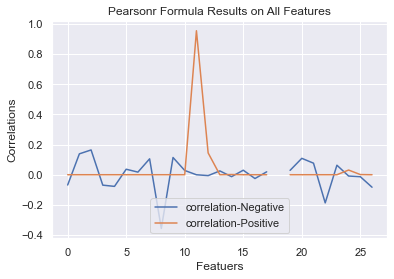

In [366]:
pearsonrResults = []
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Field_info1'], y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Field_info2'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Field_info3'], y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Field_info4'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Coverage_info1'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Coverage_info2'],  y) ) 
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Coverage_info3'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Sales_info1'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Sales_info2'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Sales_info3'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Sales_info4'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Sales_info5'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Personal_info1'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Personal_info2'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Personal_info3'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Personal_info4'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Personal_info5'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Property_info1'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Property_info2'],  y) )
warnings.filterwarnings("ignore")
# result_df1['Property_info2'].describe()
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Property_info3'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Property_info4'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Property_info5'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Geographic_info1'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Geographic_info2'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Geographic_info3'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Geographic_info4'],  y) )
pearsonrResults.append( scipy.stats.pearsonr(result_df1['Geographic_info5'],  y) )
count=0
for pr in pearsonrResults:
#     array(pr)
    count=count+1
    print((count),"-Correlations Negative ",pr[0]," Correlations Positive ",pr[1])

from pylab import plot, title, xlabel, ylabel, savefig, legend, array

values = pearsonrResults
noOfFeatuers = array([27])

for temp in zip(*values):
    plot( array(temp))
title('Pearsonr Formula Results on All Features')
xlabel('Featuers')
ylabel('Correlations')
legend(['correlation-Negative', 'correlation-Positive'], loc='lower center')
plt.show()



In [367]:
# pip install mlxtend

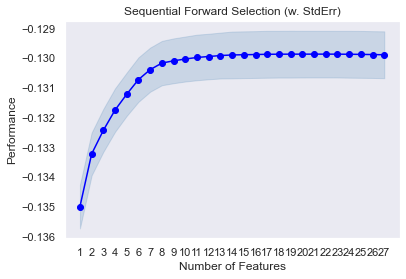

<Figure size 720x720 with 0 Axes>

In [368]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
X, y 
lr = LinearRegression()
sfs = SFS(lr, 
          k_features=27, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)
r=RandomForestClassifier(max_depth=5, n_estimators=24, random_state=10)
r = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.figure(figsize = (10,10))
plt.show()

In [369]:
X_train.head()

,Field_info2,Coverage_info1,Sales_info1,Sales_info3,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Field_info3,Field_info4,Coverage_info3,Sales_info4,Property_info3,Geographic_info5
2528,0.9023,2,1,14,0,5,4,17,5,0,4,3,15,2
9996,0.9769,8,1,23,1,19,14,6,1,0,6,0,7,3
3767,0.9403,3,1,20,0,18,2,4,6,0,4,0,1,0
16763,0.9919,25,0,21,1,25,4,19,5,0,4,2,15,2
43150,0.9403,22,0,4,1,25,2,8,7,0,9,3,12,0


In [370]:
# Load libraries
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create a function to decide number of components 
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components
    
# Create and run an LDA 
lda = LinearDiscriminantAnalysis(n_components=None)
X_lda = lda.fit( X_train, y_train)

# Create array of explained variance ratios
lda_var_ratios = lda.explained_variance_ratio_

# Run function
select_n_components(lda_var_ratios, 0.95)

1

[0.03706023 0.07310824 0.03013862 0.01748155 0.12593202 0.04689348
 0.07719574 0.13191347 0.00093743 0.01847735 0.         0.01742835
 0.07266103 0.02682208 0.05976183 0.00531913 0.00811678 0.02902887
 0.00218133 0.04815854 0.05827694 0.00168426 0.04073134 0.01717163
 0.03974733 0.00482391 0.0089485 ]


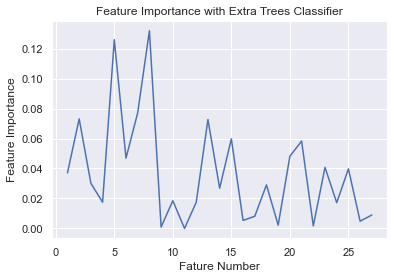

<class 'numpy.ndarray'>
0.0370602347330937
0.0731082359505717
0.030138618687737477
0.0174815497918705
0.1259320202376202
0.04689347937941905
0.07719573974755356
0.1319134695445459
0.0009374315805418263
0.018477352477197492
0.0
0.017428353462124905
0.07266102747270797
0.02682207619854694
0.05976182736163958
0.0053191329925807405
0.008116782647050761
0.02902887454271719
0.0021813334147024236
0.04815854409560857
0.05827694194766987
0.001684262280828787
0.04073134418841497
0.01717162772103547
0.03974732858893887
0.004823908572687496
0.008948502382593898


In [371]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# data = pd.read_csv("D://Blogs//train.csv")
model = ExtraTreesClassifier()
model.fit(X, y)

print(model.feature_importances_)
y1 = model.feature_importances_
x1 = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27)
plt.title("Feature Importance with Extra Trees Classifier") 
plt.xlabel("Fature Number") 
plt.ylabel("Feature Importance") 
plt.plot(x1,y1) 
plt.show()

# ds = pd.DataFrame.from_dict(model.feature_importances_)
print(type(model.feature_importances_))
for i in model.feature_importances_:
    print(i)

In [372]:
# features_to_keep

In [373]:
# print(X_train)

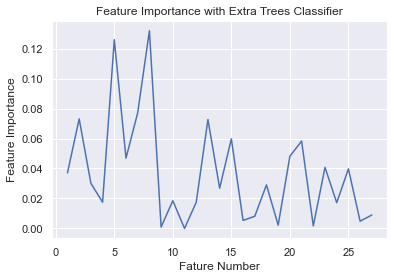

<class 'numpy.ndarray'>
0.0370602347330937
0.0731082359505717
0.030138618687737477
0.0174815497918705
0.1259320202376202
0.04689347937941905
0.07719573974755356
0.1319134695445459
0.0009374315805418263
0.018477352477197492
0.0
0.017428353462124905
0.07266102747270797
0.02682207619854694
0.05976182736163958
0.0053191329925807405
0.008116782647050761
0.02902887454271719
0.0021813334147024236
0.04815854409560857
0.05827694194766987
0.001684262280828787
0.04073134418841497
0.01717162772103547
0.03974732858893887
0.004823908572687496
0.008948502382593898


In [374]:
from matplotlib import pyplot as plt 

y1 = model.feature_importances_
x1 = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27)
plt.title("Feature Importance with Extra Trees Classifier") 
plt.xlabel("Fature Number") 
plt.ylabel("Feature Importance") 
plt.plot(x1,y1) 
plt.show()
# ds = pd.DataFrame.from_dict(model.feature_importances_)
print(type(model.feature_importances_))
for i in model.feature_importances_: 
    print(i)

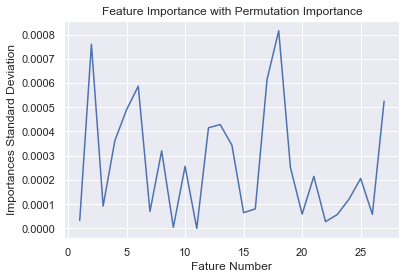

[3.29038995e-05 7.59902610e-04 9.18650198e-05 3.62013436e-04
 4.89258633e-04 5.86682243e-04 6.96532270e-05 3.20165670e-04
 4.79386385e-06 2.56375871e-04 0.00000000e+00 4.15249961e-04
 4.28585609e-04 3.43426435e-04 6.51252281e-05 8.05977642e-05
 6.13641621e-04 8.15577002e-04 2.51219608e-04 5.90162522e-05
 2.14798627e-04 2.79070777e-05 5.72594211e-05 1.20441689e-04
 2.06012236e-04 5.81664261e-05 5.24849648e-04]


In [375]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
clf = LogisticRegression().fit(X, y)
result = permutation_importance(clf, X, y, n_repeats=10,random_state=0)
result.importances_mean

result.importances_std
y1 = result.importances_std
x1= (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27)
plt.title("Feature Importance with Permutation Importance") 
plt.xlabel("Fature Number") 
plt.ylabel("Importances Standard Deviation") 
plt.plot(x1,y1) 
plt.show()
# ds = pd.DataFrame.from_dict(model.feature_importances_)
print((y1))
# X_train.columns  

In [376]:

# X_train.describe()  

In [377]:
# dp=X_train.to_numpy()
# dsd=np.transpose(dp)
# dp
# model
# (model.feature_importances_[10])

In [378]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features


               Specs        Score
17       Field_info3  2620.298444
4        Sales_info2   587.140995
13  Geographic_info1   500.893351
26  Geographic_info5   449.971145
16       Field_info1   376.810227
18       Field_info4   276.868383
11    Property_info4   247.925061
0        Field_info2   190.255549
3        Sales_info1   176.332335
24    Property_info3   111.719205


Text(0.5, 0, 'Mutual Information Score')

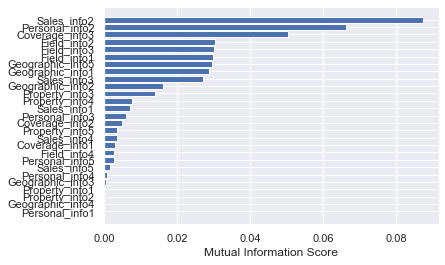

In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import feature_selection as fs
%matplotlib inline
mi_score = fs.mutual_info_classif(
    X, 
    y, 
    n_neighbors=10,
    random_state=22)
sorted_idx = np.argsort(mi_score)
mi_scoredf = pd.DataFrame(
    mi_score[sorted_idx[::-1]], 
    index=X.columns[sorted_idx[::-1]], 
    columns=['mi_score'])
plt.barh(
    X.columns[sorted_idx], 
    mi_score[sorted_idx])   
plt.xlabel("Mutual Information Score") 


In [380]:
X

,Field_info2,Coverage_info1,Coverage_info2,Sales_info1,Sales_info2,Sales_info3,Sales_info5,Personal_info2,Personal_info4,Personal_info5,...,Field_info3,Field_info4,Coverage_info3,Sales_info4,Personal_info1,Personal_info3,Property_info1,Property_info3,Geographic_info4,Geographic_info5
0,0.300369,0.230769,0.041667,1.0,1.00,0.434783,0.820409,0.000000,0.0,0.4,...,6,0,3,5,0,22,0,1,0,0
1,0.697417,0.230769,0.875000,1.0,1.00,0.000000,0.081479,0.000000,0.0,0.0,...,1,0,5,2,0,13,0,1,0,3
2,0.300369,0.269231,0.875000,1.0,1.00,0.434783,0.888219,0.730769,0.0,0.4,...,6,0,3,6,0,22,0,1,0,0
3,0.034686,0.076923,0.875000,1.0,1.00,0.434783,0.103324,0.230769,0.0,0.4,...,0,0,5,3,0,22,0,12,0,3
4,1.000000,0.538462,0.875000,1.0,0.50,0.826087,0.910450,0.269231,0.0,0.0,...,4,0,4,0,0,2,0,15,0,2
5,0.692989,0.307692,0.875000,1.0,0.50,0.826087,0.866151,0.192308,0.0,0.0,...,4,0,4,0,0,29,0,15,0,2
6,0.000000,0.230769,0.875000,1.0,1.00,0.434783,0.812219,0.307692,0.0,0.0,...,3,1,10,5,0,13,0,11,0,1
7,0.091513,0.230769,0.875000,1.0,0.50,0.434783,0.827303,0.230769,0.0,0.0,...,0,1,5,0,0,20,0,1,0,3
8,0.692989,0.346154,0.875000,1.0,1.00,0.826087,0.784166,0.923077,0.0,0.0,...,4,0,4,5,0,19,1,1,0,2
9,0.929889,0.192308,0.875000,0.0,1.00,0.434783,0.449582,0.000000,0.0,0.0,...,4,0,4,2,0,29,0,15,0,2


In [381]:
X = X.drop([
#     'Quote_Flag',       
                            'Field_info1',  
#                            'Field_info2',
#                            'Field_info3',
#                            'Field_info4',
                           'Coverage_info2', 
#                            'Coverage_info1',
#                            'Coverage_info3',
#                              'Sales_info1',
                           'Sales_info2',  
#                            'Sales_info3',
#                            'Sales_info4',
                           'Sales_info5',
                     'Personal_info1',
                           'Personal_info2', 
                               'Personal_info3',
                               'Personal_info4',
                               'Personal_info5',
                         'Property_info1',
                               'Property_info2',
#                                'Property_info3',
#                                'Property_info4',
#                            'Property_info5',
#                         'Geographic_info1',
#                            'Geographic_info2',
                           'Geographic_info3',
                           'Geographic_info4',
#                            'Geographic_info5',
#                      'Quote_Date'
                       ], axis=1)

# y_train = result_df1['Quote_Flag']
#Selecting Same Featurs of Unkmown Test Data
X_UnknowData = X_UnknowData.drop([
#     'Quote_Flag',      
                            'Field_info1',  
#                            'Field_info2',
#                            'Field_info3',
#                            'Field_info4',
                           'Coverage_info2', 
#                            'Coverage_info1',
#                            'Coverage_info3',
#                              'Sales_info1',
                           'Sales_info2',  
#                            'Sales_info3',
#                            'Sales_info4',
                           'Sales_info5',
                     'Personal_info1',
                           'Personal_info2', 
                               'Personal_info3',
                               'Personal_info4',
                               'Personal_info5',
                         'Property_info1',
                               'Property_info2',
#                                'Property_info3',
#                                'Property_info4',
#                            'Property_info5',
#                         'Geographic_info1',
#                            'Geographic_info2',
                           'Geographic_info3',
                           'Geographic_info4',
#                            'Geographic_info5',
#                      'Quote_Date'
                       ], axis=1)
# y_test = result_df2['Quote_Flag']

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 10)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_UnknowData.shape)


(46935, 14)
(46935,)
(15645, 14)
(15645,)
(41721, 14)


# Random Forest

In [382]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import pandas as pd
param_grid = {'max_depth': [3, 5, 10],'min_samples_split': [2, 5, 10]}
base_estimator = RandomForestClassifier(random_state=10)
X, y = make_classification(n_samples=1000, random_state=10)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=100,factor=2, resource='n_estimators',
                         max_resources=30).fit(X_train,  y_train)
sh.best_estimator_
RandomForestClassifier(max_depth=5, n_estimators=24, random_state=10)

RandomForestClassifier(max_depth=5, n_estimators=24, random_state=10)

In [383]:
print("[3] Fitting model..")
print("\t-Random Forest Classifier")
# rfc =RandomForestClassifier(max_depth=5, n_estimators=24, random_state=10)
# rfc = RandomForestClassifier(n_estimators=10, random_state=10)
rfc =sh.best_estimator_.fit(X_train,  y_train)
y_pred_rfc = sh.best_estimator_.fit(X_train,  y_train).predict(X_test)


[3] Fitting model..
	-Random Forest Classifier


[4] Evaluating model..

 Accuracy_score for Random Forest Classifier = 0.8136784915308405 

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     12730
           1       0.00      0.00      0.00      2915

    accuracy                           0.81     15645
   macro avg       0.41      0.50      0.45     15645
weighted avg       0.66      0.81      0.73     15645

Accuracy :  81.36784915308405
K-fold cross-validation results:
RandomForestClassifier average accuracy: 0.787 (+/-0.005)
RandomForestClassifier average log_loss: 1.764 (+/-0.089)
RandomForestClassifier average auc: 0.710 (+/-0.008)


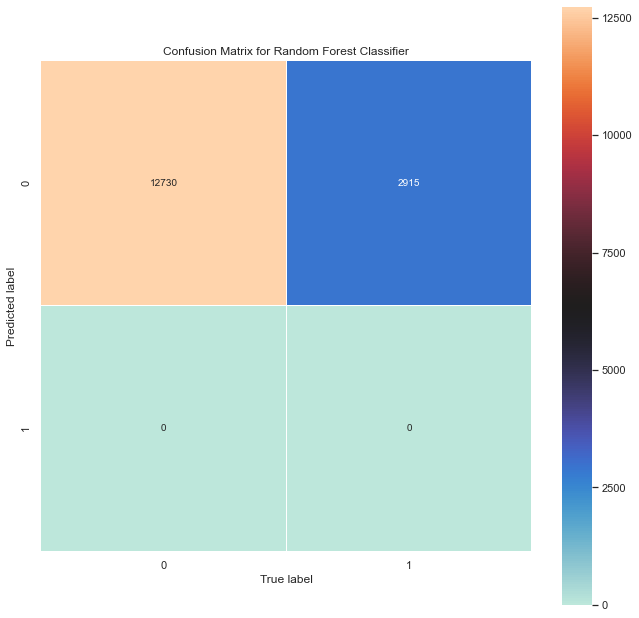

In [384]:
# Evaluation
print("[4] Evaluating model..")
report_score(y_test, y_pred_rfc,'Random Forest Classifier')

from sklearn.metrics import mean_absolute_error 
y_pred_rfc = rfc.predict(X_test)
print ("Accuracy : ", accuracy_score(y_test,y_pred_rfc)*100)
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(knn, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(rfc.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))


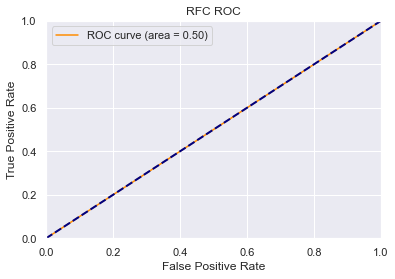

Average precision-recall score : 0.18632150846915949


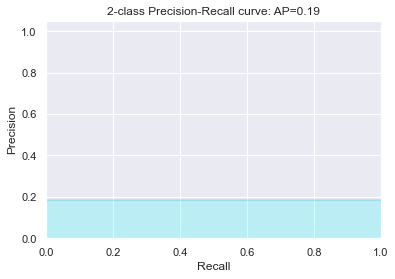

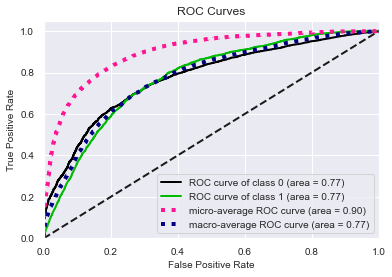

In [385]:
# y_predictions = rfc.predict(X_test)
get_prec_recall (y_test,y_pred_rfc)
import scikitplot as skplt
import matplotlib.pyplot as plt
# y_true = classes# ground truth labels
y_probas = sh.best_estimator_.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

# Naive Bayes

In [387]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
gs_NB = GaussianNB()
# from lwoku import RANDOM_STATE, N_JOBS, VERBOSE, get_prediction
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# from grid_search_utils import plot_grid_search, table_grid_search


In [388]:
cv_method = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=999)

In [389]:
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing':np.logspace(0,-9, num=100)}
# {'var_smoothing':[1, 2, 3]}
gs_NB = GridSearchCV(estimator=GaussianNB(), param_grid=params_NB, cv=cv_method,verbose=1,scoring='accuracy')
Data_transformed = PowerTransformer().fit_transform(X_train)
gs_NB.fit(Data_transformed, y_train);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [390]:
gs_NB.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__priors', 'estimator__var_smoothing', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [391]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']
# predict the target on the test dataset
predict_test = gs_NB.predict(X_test)
# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)


accuracy_score on test dataset :  0.8137424097155641


In [392]:
gs_NB_pred = gs_NB.predict(X_test)
print(classification_report(y_test,gs_NB_pred))
print ("Accuracy : ", accuracy_score(y_test,gs_NB_pred)*100)

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     12730
           1       0.57      0.00      0.00      2915

    accuracy                           0.81     15645
   macro avg       0.69      0.50      0.45     15645
weighted avg       0.77      0.81      0.73     15645

Accuracy :  81.37424097155642


Model Accuracy for GNB: 81.37424097155642


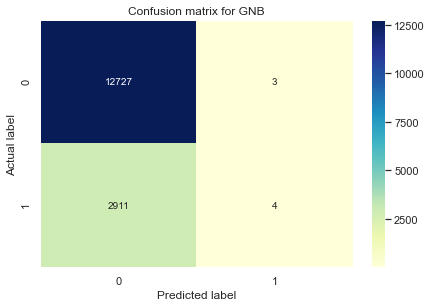

In [393]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, gs_NB_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for GNB', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for GNB:",metrics.accuracy_score(y_test, gs_NB_pred) * 100)

Average precision-recall score : 0.1868499572691038


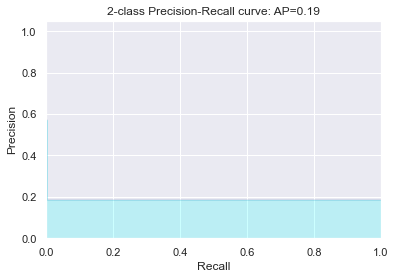

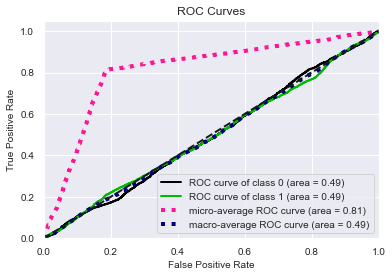

In [396]:

get_prec_recall (y_test,gs_NB_pred)
import scikitplot as skplt
import matplotlib.pyplot as plt
# y_true = classes# ground truth labels
y_probas = gs_NB.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

In [395]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(gs_NB, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(gs_NB.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
K-fold cross-validation results:
GridSearchCV average accuracy: 0.807 (+/-0.000)
GridSearchCV average log_loss: 0.483 (+/-0.001)
GridSearchCV average auc: 0.614 (+/-0.010)


# KNN

In [397]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(X_train, y_train)
print("train shape: " + str(X_train.shape))
print("score on test: " + str(knn.score(X_test, y_test)))
print("score on train: "+ str(knn.score(X_train, y_train)))

train shape: (46935, 14)
score on test: 0.7978267817193991
score on train: 0.8482369234047087


In [398]:
#MAE L1 loss function - Should be close to 0
from sklearn.metrics import mean_absolute_error 
knn_pred = knn.predict(X_test)

print(classification_report(y_test,knn_pred))
print ("Accuracy : ", accuracy_score(y_test,knn_pred)*100)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     12730
           1       0.44      0.28      0.34      2915

    accuracy                           0.80     15645
   macro avg       0.64      0.60      0.61     15645
weighted avg       0.77      0.80      0.78     15645

Accuracy :  79.78267817193992


Model Accuracy for KNN: 79.78267817193992


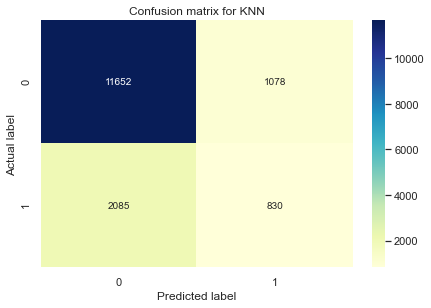

In [399]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, knn_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for KNN', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for KNN:",metrics.accuracy_score(y_test, knn_pred) * 100)

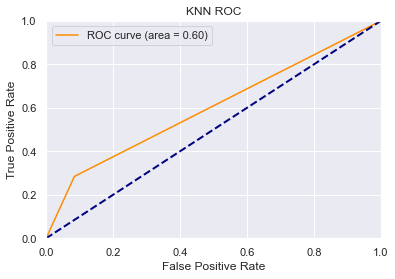

Average precision-recall score : 0.2571317479821067


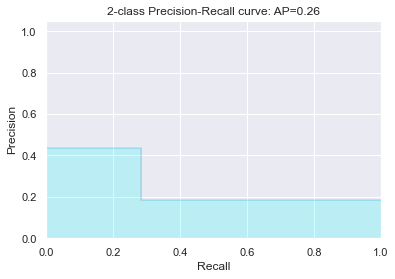

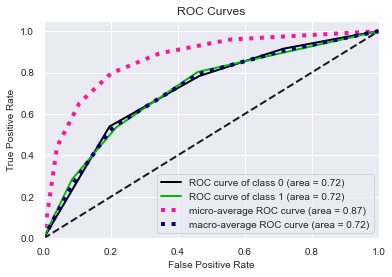

In [400]:
get_roc(y_test,knn_pred,'KNN ROC')
get_prec_recall (y_test,knn_pred)
import scikitplot as skplt
import matplotlib.pyplot as plt
# y_true = classes# ground truth labels
y_probas = knn.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

In [401]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(knn, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(knn.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
KNeighborsClassifier average accuracy: 0.787 (+/-0.005)
KNeighborsClassifier average log_loss: 1.764 (+/-0.089)
KNeighborsClassifier average auc: 0.710 (+/-0.008)


In [402]:
# print(knn.predict_proba(X_test)[:20])

In [403]:
from sklearn.model_selection import GridSearchCV
gird_params = {
    'n_neighbors' : [1,2,4,5],
    'weights' : ['uniform' , 'distance'],
    'metric' : ['euclidean','manhattan']
}
gs = GridSearchCV( KNeighborsClassifier(),
                  gird_params,
                  verbose =1,
                  cv =5,
                  n_jobs = -1
)
gs_results = gs.fit( X_train, y_train)
    
knn_pred = gs_results.predict(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Model Accuracy for KNN: 80.68392457654203


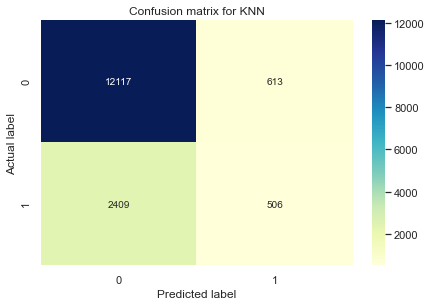

In [404]:
# knn_pred = gs.predict(X_test)
# Making the Confusion Matrix
cm = confusion_matrix(y_test, knn_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for KNN', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for KNN:",metrics.accuracy_score(y_test, knn_pred) * 100)

In [405]:
gs_results.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=4)

In [406]:
gs_results.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'uniform'}

# logistic Regression

In [407]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("score on test: " + str(lr.score(X_test, y_test)))
print("score on train: "+ str(lr.score(X_train, y_train)))
lr_pred = lr.predict(X_test)
print(classification_report(y_test,lr_pred))
print ("Accuracy : ", accuracy_score(y_test,lr_pred)*100)

score on test: 0.8125279642058165
score on train: 0.8055182699478002
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     12730
           1       0.40      0.01      0.02      2915

    accuracy                           0.81     15645
   macro avg       0.61      0.50      0.46     15645
weighted avg       0.74      0.81      0.73     15645

Accuracy :  81.25279642058165


Model Accuracy for Logistic Regrassion - Ensemble Learning III: 81.25279642058165


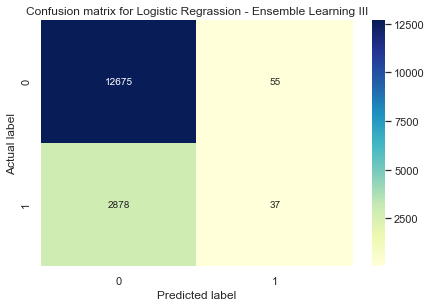

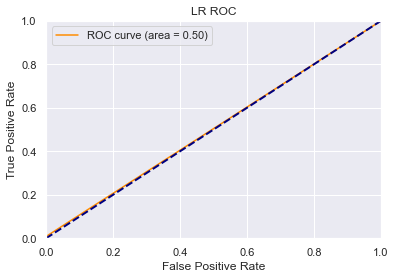

Average precision-recall score : 0.18906131600578033


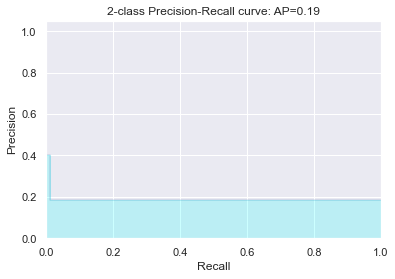

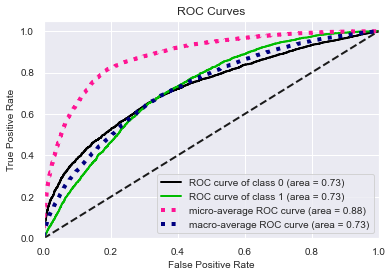

In [409]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, lr_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for Logistic Regrassion - Ensemble Learning III', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Logistic Regrassion - Ensemble Learning III:",metrics.accuracy_score(y_test, lr_pred) * 100)
get_roc(y_test,lr_pred,'LR ROC')
get_prec_recall (y_test,lr_pred)
import scikitplot as skplt
import matplotlib.pyplot as plt
# y_true = classes# ground truth labels
y_probas = lr.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

In [410]:

from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(lr, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(lr.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.806 (+/-0.001)
LogisticRegression average log_loss: 0.440 (+/-0.004)
LogisticRegression average auc: 0.723 (+/-0.007)


# Decision Tree

In [411]:
from sklearn.tree import DecisionTreeClassifier
DecisionTree_clf = DecisionTreeClassifier()
DecisionTree_clf.fit(X_train, y_train)
print("score on test: "  + str(DecisionTree_clf.score(X_test, y_test)))
print("score on train: " + str(DecisionTree_clf.score(X_train, y_train)))
DecisionTree_pred = DecisionTree_clf.predict(X_test)
print(classification_report(y_test,DecisionTree_pred))
print ("Accuracy : ", accuracy_score(y_test,DecisionTree_pred)*100)

score on test: 0.7595397890699904
score on train: 0.9980185362735698
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12730
           1       0.37      0.41      0.39      2915

    accuracy                           0.76     15645
   macro avg       0.62      0.63      0.62     15645
weighted avg       0.77      0.76      0.76     15645

Accuracy :  75.95397890699904


Model Accuracy for Decision Tree: 75.95397890699904


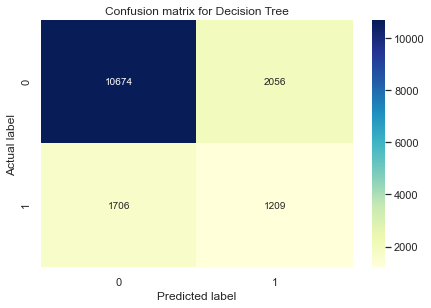

In [412]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, DecisionTree_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for Decision Tree', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Decision Tree:",metrics.accuracy_score(y_test, DecisionTree_pred) * 100)

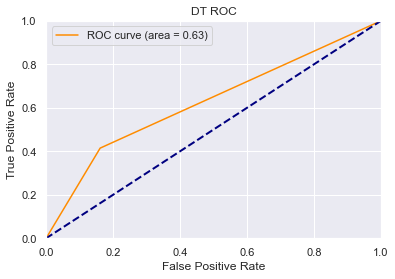

Average precision-recall score : 0.2626230771406261


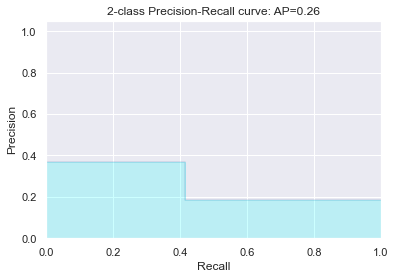

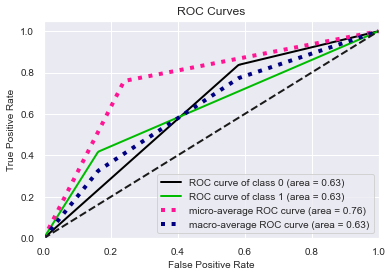

In [413]:
get_roc(y_test,DecisionTree_pred,'DT ROC')
get_prec_recall (y_test,DecisionTree_pred)
import scikitplot as skplt
import matplotlib.pyplot as plt
# y_true = classes# ground truth labels
y_probas = DecisionTree_clf.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

In [414]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = DecisionTree_clf, X = X_train, y = y_train, cv = 10)
accuracies.mean()

0.7514644552607203

In [415]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(DecisionTree_clf, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(DecisionTree_clf.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
DecisionTreeClassifier average accuracy: 0.753 (+/-0.005)
DecisionTreeClassifier average log_loss: 8.500 (+/-0.166)
DecisionTreeClassifier average auc: 0.621 (+/-0.007)


# ANN Classification

In [416]:
from sklearn.neural_network import MLPClassifier

ann_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

ann_clf.fit(X_train, y_train)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [417]:
print("score on test: " + str(lr.score(X_test, y_test)))
print("score on train: "+ str(lr.score(X_train, y_train)))
ann_pred = ann_clf.predict(X_test)
print(classification_report(y_test,ann_pred))
print (" Accuracy : ", accuracy_score(y_test,ann_pred)*100)

score on test: 0.8125279642058165
score on train: 0.8055182699478002
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     12730
           1       0.00      0.00      0.00      2915

    accuracy                           0.81     15645
   macro avg       0.41      0.50      0.45     15645
weighted avg       0.66      0.81      0.73     15645

 Accuracy :  81.36784915308405


Model Accuracy for Decision Tree: 81.36784915308405


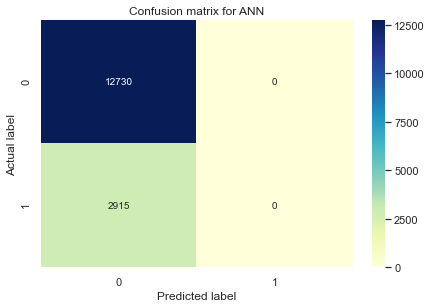

In [418]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, ann_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for ANN', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Decision Tree:",metrics.accuracy_score(y_test, ann_pred) * 100)

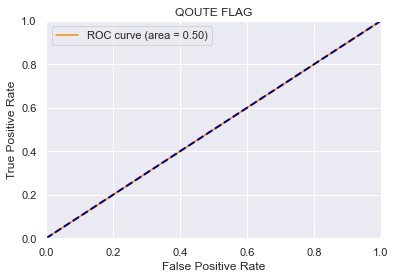

Average precision-recall score : 0.18632150846915949


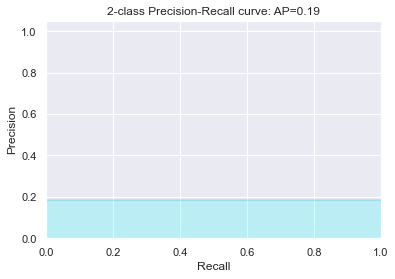

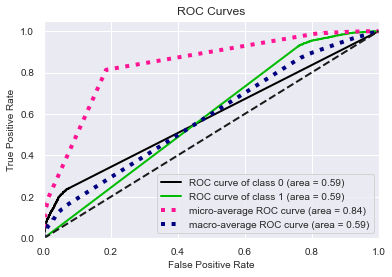

In [419]:
get_roc(y_test,ann_pred,'QOUTE FLAG')
get_prec_recall (y_test,ann_pred)
import scikitplot as skplt
import matplotlib.pyplot as plt
# y_true = classes# ground truth labels
y_probas = ann_clf.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

In [422]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(ann_clf, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(ann_clf.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
MLPClassifier average accuracy: 0.807 (+/-0.000)
MLPClassifier average log_loss: 0.472 (+/-0.001)
MLPClassifier average auc: 0.586 (+/-0.005)


# Bagging Decision Tree - Ensemble Learning I

In [423]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_train, y_train)
print("score on test: " + str(bg.score(X_test, y_test)))
print("score on train: "+ str(bg.score(X_train, y_train)))


score on test: 0.8122083732821987
score on train: 0.9237669116863748


In [424]:
bg_pred = bg.predict(X_test)
print(classification_report(y_test,bg_pred))
print ("Accuracy : ", accuracy_score(y_test,bg_pred)*100)

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     12730
           1       0.49      0.26      0.34      2915

    accuracy                           0.81     15645
   macro avg       0.67      0.60      0.62     15645
weighted avg       0.78      0.81      0.79     15645

Accuracy :  81.22083732821987


Model Accuracy for Bagging Decision Tree - Ensemble Learning I: 81.22083732821987


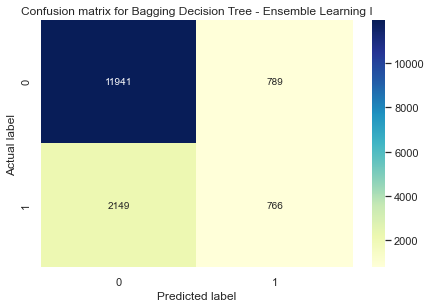

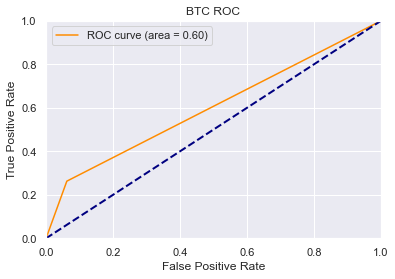

Average precision-recall score : 0.2668061646421046


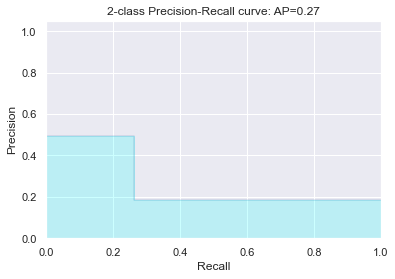

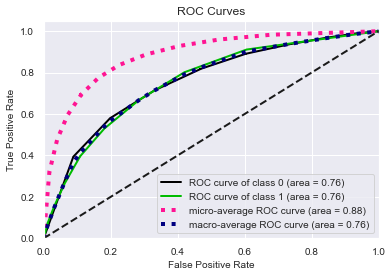

In [425]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, bg_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for Bagging Decision Tree - Ensemble Learning I', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Bagging Decision Tree - Ensemble Learning I:",metrics.accuracy_score(y_test, bg_pred) * 100)
get_roc(y_test,bg_pred,'BTC ROC')
get_prec_recall (y_test,bg_pred)
import scikitplot as skplt
import matplotlib.pyplot as plt
# y_true = classes# ground truth labels
y_probas = bg.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

In [426]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(bg, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(bg.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
BaggingClassifier average accuracy: 0.801 (+/-0.003)
BaggingClassifier average log_loss: 0.976 (+/-0.074)
BaggingClassifier average auc: 0.747 (+/-0.006)


# Boosting Decision Tree - Ensemble Learning II

In [427]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(X_train, y_train)
adb_pred = adb.predict(X_test)
print("score on test: " + str(adb.score(X_test, y_test)))
print("score on train: "+ str(adb.score(X_train, y_train)))
print(classification_report(y_test,adb_pred))
print ("Accuracy : ", accuracy_score(y_test,adb_pred)*100)

score on test: 0.8186641099392777
score on train: 0.8126558005752637
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     12730
           1       0.55      0.14      0.22      2915

    accuracy                           0.82     15645
   macro avg       0.69      0.56      0.56     15645
weighted avg       0.78      0.82      0.77     15645

Accuracy :  81.86641099392777


Model Accuracy for Boosting Decision Tree - Ensemble Learning II: 81.86641099392777


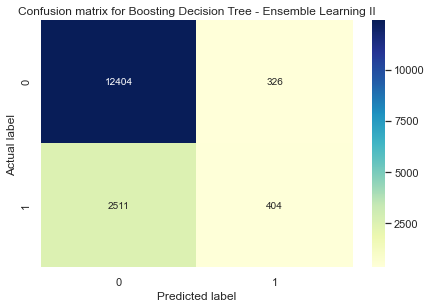

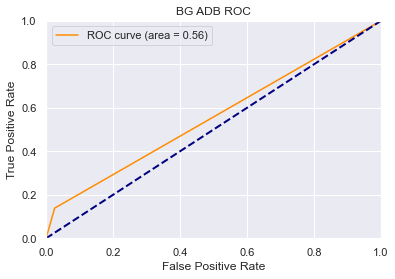

Average precision-recall score : 0.23719961214747687


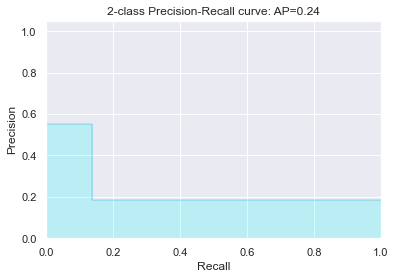

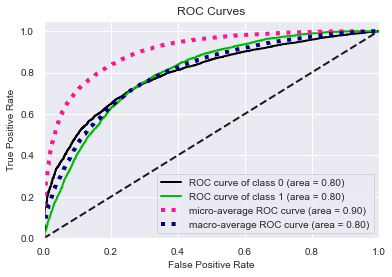

In [428]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, adb_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for Boosting Decision Tree - Ensemble Learning II', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Boosting Decision Tree - Ensemble Learning II:",metrics.accuracy_score(y_test, adb_pred) * 100)
get_roc(y_test,adb_pred,'BG ADB ROC')
get_prec_recall (y_test,adb_pred)
import scikitplot as skplt
import matplotlib.pyplot as plt
# y_true = classes# ground truth labels
y_probas = adb.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

In [429]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(adb, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(adb.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
AdaBoostClassifier average accuracy: 0.809 (+/-0.003)
AdaBoostClassifier average log_loss: 0.562 (+/-0.003)
AdaBoostClassifier average auc: 0.790 (+/-0.007)


# Random Forest - Ensemble Learning III

In [430]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(X_train, y_train)
print("score on test: " + str(rf.score(X_test, y_test)))
print("score on train: "+ str(rf.score(X_train, y_train)))
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))
print ("Accuracy : ", accuracy_score(y_test,rf_pred)*100)

score on test: 0.8138063279002876
score on train: 0.8086928731224033
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     12730
           1       0.56      0.00      0.01      2915

    accuracy                           0.81     15645
   macro avg       0.68      0.50      0.45     15645
weighted avg       0.77      0.81      0.73     15645

Accuracy :  81.38063279002876


Model Accuracy for Random Forest - Ensemble Learning III: 81.38063279002876


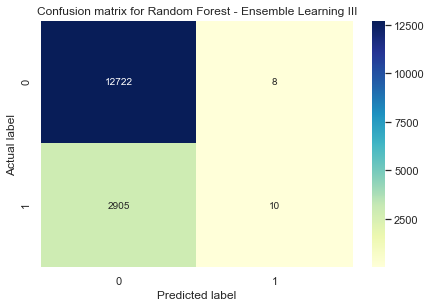

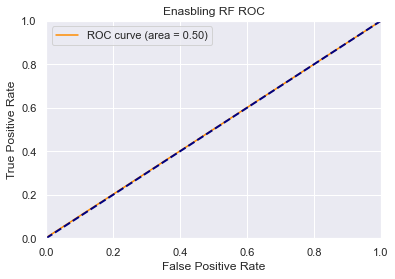

Average precision-recall score : 0.1875881775843787


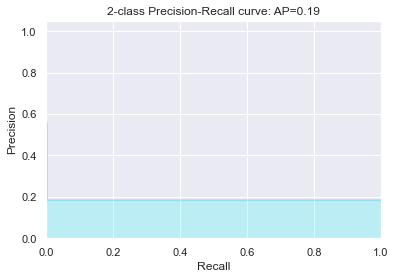

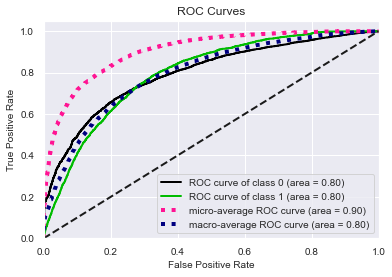

In [431]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, rf_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for Random Forest - Ensemble Learning III', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Random Forest - Ensemble Learning III:",metrics.accuracy_score(y_test, rf_pred) * 100)
get_roc(y_test,rf_pred,'Enasbling RF ROC')
get_prec_recall (y_test,rf_pred)
import scikitplot as skplt
import matplotlib.pyplot as plt
# y_true = classes# ground truth labels
y_probas = rf.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

In [432]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(rf, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(rf.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
RandomForestClassifier average accuracy: 0.808 (+/-0.000)
RandomForestClassifier average log_loss: 0.402 (+/-0.003)
RandomForestClassifier average auc: 0.792 (+/-0.006)


# Voting Classifier - Ensemble Learning IV

In [439]:
from sklearn.ensemble import VotingClassifier
# 1) naive bias = mnb ('mnb',mnb)
# 2) logistic regression =lr  ('lr',lr),
# 3) random forest =rf
# 4) support vector machine = svm ,('svm',svm) ('svm',svcclassifier)
evc=VotingClassifier(estimators=[('adb',adb),('lr',lr),('rf',rfc),('nb',gs_NB),('ann',ann_clf),('knn',gs_results),('bg',bg) ],voting='hard')
evc.fit(X_train, y_train)
print("score on test: " + str(evc.score(X_test, y_test)))
print("score on train: "+ str(evc.score(X_train, y_train)))

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
score on test: 0.8139341642697348
score on train: 0.8077767124746991


In [440]:
evc_pred = evc.predict(X_test)
print(classification_report(y_test,evc_pred))
print ("Accuracy : ", accuracy_score(y_test,evc_pred)*100)


              precision    recall  f1-score   support

           0       0.81      1.00      0.90     12730
           1       0.83      0.00      0.00      2915

    accuracy                           0.81     15645
   macro avg       0.82      0.50      0.45     15645
weighted avg       0.82      0.81      0.73     15645

Accuracy :  81.39341642697347


Model Accuracy for Voting Classifier: 81.39341642697347


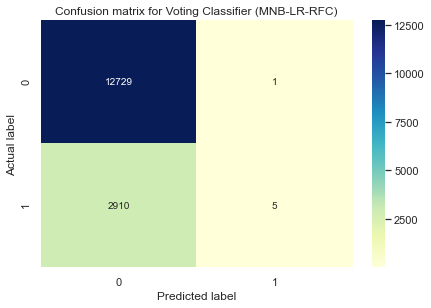

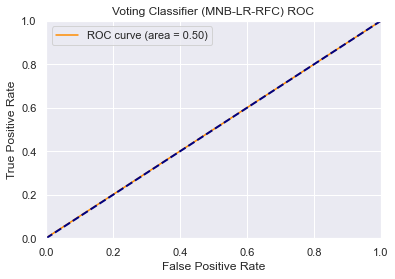

Average precision-recall score : 0.18743130576738276


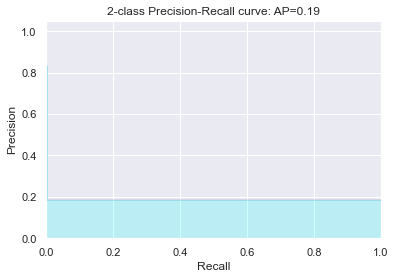

In [441]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, evc_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for Voting Classifier (MNB-LR-RFC)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Voting Classifier:",metrics.accuracy_score(y_test, evc_pred) * 100)
get_roc(y_test,evc_pred,'Voting Classifier (GNB-LR-RFC-) ROC')
get_prec_recall (y_test,evc_pred)

In [443]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

results = cross_validate(evc, X_train, y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(evc.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 5 folds for each of 16 candidates, totalling 

# Genrating & Exporting Predictions on Unknown Data

In [449]:
UnknowData.shape


(41721, 29)

In [448]:
X_UnknowData.shape

(41721, 14)

In [452]:
# Subjecting to ADB Model For predictions
np_pred_Unknown=adb.predict(X_UnknowData)
np_pred_Unknown

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [456]:
df_pred_Unknown = pd.DataFrame(np_pred_Unknown, columns = ['Quote_Flag'])
df_pred_Unknown.head()

,Quote_Flag
0,0
1,0
2,0
3,0
4,0


In [457]:
df_id =UnknowData['Quote_Id']
df_merged = pd.concat([df_id, df_pred_Unknown], axis=1)
df_merged.head()


,Quote_Id,Quote_Flag
0,1,0
1,4,0
2,5,0
3,7,0
4,8,0


In [458]:
df_merged.to_csv(r'Kaggle-Submission-Ramdom-Solution.csv', index = False)